In [1]:
!pip install prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
#from google.colab import files
import random

import prettytable

import plotly.graph_objects as go

from scipy.optimize import minimize

In [3]:
random.seed(0)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**covariance**

In [5]:
# negative covariance: if one stock goes up, the other goes down. Positive: if a goes up, b goes up.

Final deliverable: notebook with calculations and PDF file where we show results (numbers, plots) and write comments.

# Building the dataset

## Get ISIN codes

In [6]:
industry_code = 1010.0 # based on Global Industry Classification Standard GICS

In [7]:
#df_sector = pd.read_excel("sector.xlsx")
df_sector = pd.read_excel("https://github.com/GuillaumeR16/financelecture/blob/main/sector.xlsx?raw=true")

In [8]:
df_sector

,ISIN,NAME,GICSS,GICSIG,GICSI,GICSSI,Trucost
0,AEA000201011,ABU DHABI COML.BANK,40.0,4010.0,401010.0,40101010.0,52A000
1,AEA000701010,WAHA CAPITAL,40.0,4020.0,402010.0,40201040.0,622000
2,AEA000801018,ABU DHABI ISLAMIC BANK,40.0,4010.0,401010.0,40101010.0,52A000
3,AEA001201010,AMLAK FINANCE,40.0,4020.0,402020.0,40202010.0,523000
4,AEA001501013,ARABTEC HOLDING SUSP - SUSP.30/09/20,20.0,2010.0,201030.0,20103010.0,230201
...,...,...,...,...,...,...,...
17605,ZM0000000037,ZCCM INVESTMENTS HDG.,15.0,1510.0,151040.0,15104025.0,52A000
17606,ZW0009011199,DELTA CORPORATION,30.0,3020.0,302010.0,30201010.0,312120
17607,ZW0009011298,INNSCOR AFRICA,30.0,3020.0,302020.0,30202030.0,311990
17608,ZW0009012122,ECONET WIRELESS,50.0,5010.0,501020.0,50102010.0,523000


In [9]:
df_energy = df_sector.loc[df_sector['GICSIG'] == industry_code]

In [10]:
df_energy

,ISIN,NAME,GICSS,GICSIG,GICSI,GICSSI,Trucost
14,AED000701014,DANA GAS,10.0,1010.0,101020.0,10102010.0,211111
40,AN8068571086,SCHLUMBERGER,10.0,1010.0,101010.0,10101020.0,213112
49,ARP9897X1319,YPF,10.0,1010.0,101020.0,10102010.0,324110
50,ARPERE010103,PETROBRAS ENERGIA 'B' DEAD - DELIST.22/05/18,10.0,1010.0,101020.0,10102010.0,324110
84,AT0000946652,SCHOELLER-BLECKMANN,10.0,1010.0,101010.0,10101020.0,334419
...,...,...,...,...,...,...,...
17427,VN000000TDN1,VINACOMIN - DEON,10.0,1010.0,101020.0,10102050.0,212111
17428,VN000000THT9,VINACOMIN - HA T,10.0,1010.0,101020.0,10102050.0,212111
17443,ZAE000006896,SASOL,10.0,1010.0,101020.0,10102010.0,324110
17539,ZAE000151353,MVELASERVE DEAD - 12/11/13,10.0,1010.0,101010.0,10101010.0,561300


In [11]:
energy_isin = df_energy['ISIN'].values.tolist()

In [12]:
len(energy_isin)
energy_isin[:4]

['AED000701014', 'AN8068571086', 'ARP9897X1319', 'ARPERE010103']

In [13]:
"""
energy_isin_us = [i for i in energy_isin if i.startswith('US')]
len(energy_isin_us)
"""

"\nenergy_isin_us = [i for i in energy_isin if i.startswith('US')]\nlen(energy_isin_us)\n"

## Get returns

In [14]:
#df_returns = pd.read_excel("monthlyreturns.xlsx")
df_returns = pd.read_excel("https://github.com/GuillaumeR16/financelecture/blob/main/monthlyreturns.xlsx?raw=true")

In [15]:
df_returns

,Unnamed: 0,AEA000201011,AEA001501013,AEA002001013,AED000201015,AED000601016,AED000901010,AED001301012,AED001501017,AEDFXA0M6V00,...,ZAE000216537,ZAE000221370,ZAE000248498,ZAE000248506,ZAE000255360,ZAE000255915,ZAE000259479,ZAE000259701,ZAE000265971,ZAE000269890
0,2002-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.057260,NaN,NaN,-0.134138,-0.111384,NaN,NaN,NaN,-0.137366
1,2002-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.111637,NaN,NaN,0.062539,-0.224885,NaN,NaN,NaN,0.065310
2,2002-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.206354,NaN,NaN,0.007652,0.096314,NaN,NaN,NaN,-0.080122
3,2002-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.084209,NaN,NaN,0.090537,-0.104393,NaN,NaN,NaN,-0.198591
4,2002-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.513709,NaN,NaN,0.088148,0.315774,NaN,NaN,NaN,0.406500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-08-31,0.012045,1.087475,-0.050000,-0.005255,0.008674,-0.007831,0.196843,0.000000,0.0,...,-0.050505,-0.010927,-0.043621,-0.194835,-0.029779,-0.094230,-0.116505,0.310495,-0.023609,-0.106407
224,2020-09-30,0.107170,-0.364762,0.205592,0.086644,0.043186,0.059195,0.009310,-0.015075,0.0,...,0.067376,0.037906,0.091790,-0.113688,0.068572,0.107444,0.040293,0.107116,-0.056995,-0.002759
225,2020-10-31,0.008931,-0.310345,-0.019782,0.043485,-0.049642,-0.023100,0.027671,0.030612,0.0,...,-0.079734,-0.002112,0.056919,-0.162197,-0.144279,0.111818,0.158451,-0.102972,0.120879,0.037288
226,2020-11-30,0.021308,0.000000,0.334029,-0.053265,-0.008674,-0.038902,0.218399,-0.108911,0.0,...,-0.115523,0.024140,-0.007411,0.167759,-0.004542,0.000136,0.072948,0.086030,0.352941,-0.155407


In [16]:
df_returns = df_returns.rename(columns={"Unnamed: 0": "date"})
df_returns

,date,AEA000201011,AEA001501013,AEA002001013,AED000201015,AED000601016,AED000901010,AED001301012,AED001501017,AEDFXA0M6V00,...,ZAE000216537,ZAE000221370,ZAE000248498,ZAE000248506,ZAE000255360,ZAE000255915,ZAE000259479,ZAE000259701,ZAE000265971,ZAE000269890
0,2002-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.057260,NaN,NaN,-0.134138,-0.111384,NaN,NaN,NaN,-0.137366
1,2002-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.111637,NaN,NaN,0.062539,-0.224885,NaN,NaN,NaN,0.065310
2,2002-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.206354,NaN,NaN,0.007652,0.096314,NaN,NaN,NaN,-0.080122
3,2002-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.084209,NaN,NaN,0.090537,-0.104393,NaN,NaN,NaN,-0.198591
4,2002-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.513709,NaN,NaN,0.088148,0.315774,NaN,NaN,NaN,0.406500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-08-31,0.012045,1.087475,-0.050000,-0.005255,0.008674,-0.007831,0.196843,0.000000,0.0,...,-0.050505,-0.010927,-0.043621,-0.194835,-0.029779,-0.094230,-0.116505,0.310495,-0.023609,-0.106407
224,2020-09-30,0.107170,-0.364762,0.205592,0.086644,0.043186,0.059195,0.009310,-0.015075,0.0,...,0.067376,0.037906,0.091790,-0.113688,0.068572,0.107444,0.040293,0.107116,-0.056995,-0.002759
225,2020-10-31,0.008931,-0.310345,-0.019782,0.043485,-0.049642,-0.023100,0.027671,0.030612,0.0,...,-0.079734,-0.002112,0.056919,-0.162197,-0.144279,0.111818,0.158451,-0.102972,0.120879,0.037288
226,2020-11-30,0.021308,0.000000,0.334029,-0.053265,-0.008674,-0.038902,0.218399,-0.108911,0.0,...,-0.115523,0.024140,-0.007411,0.167759,-0.004542,0.000136,0.072948,0.086030,0.352941,-0.155407


In [17]:
return_cols = df_returns.columns.values.tolist()

both = []
for i in return_cols:
  if i in energy_isin:
    both.append(i)
  else:
    pass

In [18]:
print(return_cols[:4])
print(energy_isin[:4])
print(both[:4])
print(len(return_cols))
print(len(energy_isin))
print(len(both))

['date', 'AEA000201011', 'AEA001501013', 'AEA002001013']
['AED000701014', 'AN8068571086', 'ARP9897X1319', 'ARPERE010103']
['AN8068571086', 'AU000000AOE6', 'AU000000ERA9', 'AU000000ORG5']
5141
773
223


In [19]:
if 'date' not in energy_isin:
  energy_isin.insert(0, 'date')
else:
  pass
energy_isin[:4]

['date', 'AED000701014', 'AN8068571086', 'ARP9897X1319']

In [20]:
scope1 = pd.read_excel("https://github.com/GuillaumeR16/financelecture/blob/main/scope1.xlsx?raw=true")
scope2 = pd.read_excel("https://github.com/GuillaumeR16/financelecture/blob/main/scope2.xlsx?raw=true")
scope3 = pd.read_excel("https://github.com/GuillaumeR16/financelecture/blob/main/scope3.xlsx?raw=true")

In [21]:
scope1_nrg = scope1[scope1['ISIN'].isin(energy_isin)]
scope2_nrg = scope2[scope2['ISIN'].isin(energy_isin)]
scope3_nrg = scope3[scope3['ISIN'].isin(energy_isin)]
print(scope1_nrg.shape)
print(scope2_nrg.shape)
print(scope3_nrg.shape)
scope3_nrg

(773, 24)
(773, 24)
(773, 24)


,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,x2004,x2005,x2006,...,x2011,x2012,x2013,x2014,x2015,x2016,x2017,x2018,x2019,x2020
14,AED000701014,DANA GAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.328905e+04,6.719899e+04,4.062009e+04,4.298060e+04,5.199513e+04,5.090630e+04,4.546945e+04,NaN
40,AN8068571086,SCHLUMBERGER,NaN,NaN,NaN,NaN,NaN,NaN,4.168041e+06,5.029795e+06,...,1.006269e+07,1.014331e+07,1.073002e+07,1.148169e+07,8.403324e+06,6.905174e+06,8.648838e+06,8.716874e+06,8.118175e+06,NaN
49,ARP9897X1319,YPF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.092536e+06,5.887649e+06,5.605806e+06,6.403399e+06,6.239900e+06,6.860782e+06,5.520290e+06,NaN
50,ARPERE010103,PETROBRAS ENERGIA 'B' DEAD - DELIST.22/05/18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.382140e+05,7.640836e+05,NaN,NaN,NaN,NaN,NaN
84,AT0000946652,SCHOELLER-BLECKMANN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.904372e+04,1.272702e+05,1.515030e+05,1.295256e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17427,VN000000TDN1,VINACOMIN - DEON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.357555e+04,NaN
17428,VN000000THT9,VINACOMIN - HA T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.383430e+04,NaN
17443,ZAE000006896,SASOL,NaN,NaN,NaN,NaN,NaN,NaN,5.650831e+06,4.480603e+06,...,7.408594e+06,6.080224e+06,6.405420e+06,6.965466e+06,4.164291e+06,4.158845e+06,5.125700e+06,4.768286e+06,4.123679e+06,NaN
17539,ZAE000151353,MVELASERVE DEAD - 12/11/13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.282491e+04,1.253559e+04,1.188194e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
scope1_isin = scope1['ISIN'].values.tolist()

In [23]:
# count the number of NaNs in each row
n_nulls_1 = scope1_nrg.isna().sum(axis=1)

# filter the rows with 22 NaN values
no_scope_1 = scope1_nrg[n_nulls_1 == 22]

print(no_scope_1)

Empty DataFrame
Columns: [ISIN, NAME, x1999, x2000, x2001, x2002, x2003, x2004, x2005, x2006, x2007, x2008, x2009, x2010, x2011, x2012, x2013, x2014, x2015, x2016, x2017, x2018, x2019, x2020]
Index: []

[0 rows x 24 columns]


In [24]:
# count the number of NaNs in each row
n_nulls_2 = scope2_nrg.isna().sum(axis=1)

# filter the rows with 22 NaN values
no_scope_2 = scope2_nrg[n_nulls_2 == 22]

print(no_scope_2)

Empty DataFrame
Columns: [ISIN, NAME, x1999, x2000, x2001, x2002, x2003, x2004, x2005, x2006, x2007, x2008, x2009, x2010, x2011, x2012, x2013, x2014, x2015, x2016, x2017, x2018, x2019, x2020]
Index: []

[0 rows x 24 columns]


In [25]:
# count the number of NaNs in each row
n_nulls_3 = scope3_nrg.isna().sum(axis=1)

# filter the rows with 22 NaN values
no_scope_3 = scope3_nrg[n_nulls_3 == 22]

print(no_scope_3)

Empty DataFrame
Columns: [ISIN, NAME, x1999, x2000, x2001, x2002, x2003, x2004, x2005, x2006, x2007, x2008, x2009, x2010, x2011, x2012, x2013, x2014, x2015, x2016, x2017, x2018, x2019, x2020]
Index: []

[0 rows x 24 columns]


So all firms in these datasets have at least one value for each scope 1, 2, and 3. Now we must make sure that the ISINs we work with are part of these ISINs.

In [26]:
scope1_nrg_isin = scope1_nrg['ISIN'].values.tolist()
scope2_nrg_isin = scope2_nrg['ISIN'].values.tolist()
scope3_nrg_isin = scope3_nrg['ISIN'].values.tolist()

In [27]:
if set(scope1_nrg_isin) == set(scope2_nrg_isin):
    print("scope1_nrg_isin and scope2_nrg_isin have the same elements (order doesn't matter)")
else:
    print("The two lists are different")

scope1_nrg_isin and scope2_nrg_isin have the same elements (order doesn't matter)


In [28]:
if set(scope1_nrg_isin) == set(scope3_nrg_isin):
    print("scope1_nrg_isin and scope3_nrg_isin have the same elements (order doesn't matter)")
else:
    print("The two lists are different")

scope1_nrg_isin and scope3_nrg_isin have the same elements (order doesn't matter)


In [29]:
nrg_returns = df_returns[df_returns.columns.intersection(energy_isin)]
nrg_returns

,date,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,...,US8475601097,US86764P1093,RU000A0B6NK6,US87612G1013,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
0,2002-01-31,0.115662,0.152793,0.005659,-0.031864,-0.091918,NaN,NaN,NaN,-0.039490,...,NaN,0.021051,NaN,NaN,0.002783,0.040387,-0.027370,0.078207,0.455740,0.049202
1,2002-02-28,0.004551,-0.076059,0.075563,0.034254,0.947644,NaN,NaN,NaN,0.026525,...,NaN,0.032410,NaN,NaN,0.002702,0.207248,-0.255487,-0.050850,-0.100205,0.071560
2,2002-03-31,0.069747,0.250782,0.032138,0.046824,-0.051075,NaN,NaN,NaN,-0.040052,...,NaN,0.018067,NaN,NaN,0.012703,-0.055308,-0.157891,0.131839,-0.102242,0.048680
3,2002-04-30,-0.011214,0.161899,0.026068,0.072392,0.106704,NaN,NaN,NaN,-0.056528,...,NaN,0.036674,NaN,NaN,0.108710,0.130936,0.497679,0.096313,0.023116,0.123294
4,2002-05-31,-0.033508,-0.076482,-0.084686,0.054394,-0.104949,NaN,NaN,NaN,0.000000,...,NaN,-0.128155,NaN,NaN,0.063592,-0.111495,-0.186524,0.008259,-0.015311,-0.022361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,...,0.0,0.000000,-0.040000,-0.015564,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
224,2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,...,0.0,0.000000,-0.020833,-0.096853,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
225,2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,...,0.0,0.000000,-0.021277,-0.199779,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972
226,2020-11-30,0.037976,-0.019773,-0.052198,-0.102304,-0.095238,-0.081615,-0.061808,-0.135534,-0.106459,...,0.0,0.000000,-0.108696,0.190719,-0.020107,-0.009433,-0.000533,0.000000,-0.083209,-0.291075


In [30]:
start_date = '2005-01-01'
end_date = '2020-12-31'

#greater than the start date and smaller than the end date
mask = (nrg_returns['date'] >= start_date) & (nrg_returns['date'] <= end_date)

nrg_returns = nrg_returns.loc[mask]
nrg_returns

,date,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,...,US8475601097,US86764P1093,RU000A0B6NK6,US87612G1013,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
36,2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,...,NaN,-0.031204,NaN,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
37,2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,...,NaN,0.161942,NaN,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
38,2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,...,NaN,0.080660,NaN,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
39,2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,...,NaN,0.107051,NaN,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
40,2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,...,NaN,-0.066758,NaN,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,...,0.0,0.000000,-0.040000,-0.015564,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
224,2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,...,0.0,0.000000,-0.020833,-0.096853,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
225,2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,...,0.0,0.000000,-0.021277,-0.199779,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972
226,2020-11-30,0.037976,-0.019773,-0.052198,-0.102304,-0.095238,-0.081615,-0.061808,-0.135534,-0.106459,...,0.0,0.000000,-0.108696,0.190719,-0.020107,-0.009433,-0.000533,0.000000,-0.083209,-0.291075


In [31]:
nrg_returns.isnull().sum().sum()

3700

In [32]:
# drop all columns (companies) with nan values
"""
nrg_returns.dropna(axis = 1, inplace = True)

nrg_returns
"""

'\nnrg_returns.dropna(axis = 1, inplace = True)\n\nnrg_returns\n'

In [33]:
len(nrg_returns['AU000000WHC8'])

192

In [34]:
# drop all companies that have 36 NAN values (3 years) or more
too_many_nans = 36
nrg_returns = nrg_returns.dropna(thresh=len(nrg_returns) - too_many_nans, axis=1)
nrg_returns

,date,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
36,2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,...,-0.106096,NaN,-0.031204,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
37,2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,...,0.150111,NaN,0.161942,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
38,2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,...,0.057778,NaN,0.080660,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
39,2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,...,0.040317,NaN,0.107051,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
40,2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,...,0.123802,NaN,-0.066758,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,...,0.079365,0.0,0.000000,-0.040000,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
224,2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,...,-0.022058,0.0,0.000000,-0.020833,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
225,2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,...,-0.146617,0.0,0.000000,-0.021277,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972
226,2020-11-30,0.037976,-0.019773,-0.052198,-0.102304,-0.095238,-0.081615,-0.061808,-0.135534,-0.106459,...,0.215860,0.0,0.000000,-0.108696,-0.020107,-0.009433,-0.000533,0.000000,-0.083209,-0.291075


In [35]:
# for Q3
nrg_returns_date_column = nrg_returns.copy()
nrg_returns_date_column

,date,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
36,2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,...,-0.106096,NaN,-0.031204,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
37,2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,...,0.150111,NaN,0.161942,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
38,2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,...,0.057778,NaN,0.080660,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
39,2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,...,0.040317,NaN,0.107051,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
40,2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,...,0.123802,NaN,-0.066758,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,...,0.079365,0.0,0.000000,-0.040000,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
224,2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,...,-0.022058,0.0,0.000000,-0.020833,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
225,2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,...,-0.146617,0.0,0.000000,-0.021277,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972
226,2020-11-30,0.037976,-0.019773,-0.052198,-0.102304,-0.095238,-0.081615,-0.061808,-0.135534,-0.106459,...,0.215860,0.0,0.000000,-0.108696,-0.020107,-0.009433,-0.000533,0.000000,-0.083209,-0.291075


In [36]:
nrg_returns.isnull().sum().sum()

526

In [37]:
if 'date' in nrg_returns.columns.values.tolist():
  nrg_returns.set_index("date", inplace=True)
else:
  pass

nrg_returns

,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,-0.016535,...,-0.106096,NaN,-0.031204,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,-0.068279,...,0.150111,NaN,0.161942,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,0.122907,...,0.057778,NaN,0.080660,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,0.000000,...,0.040317,NaN,0.107051,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,-0.062137,...,0.123802,NaN,-0.066758,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,0.292894,...,0.079365,0.0,0.000000,-0.040000,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,-0.132470,...,-0.022058,0.0,0.000000,-0.020833,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,-0.097708,...,-0.146617,0.0,0.000000,-0.021277,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972


In [38]:
# check if all columns are in scope1_nrg_isin to see if all of them have scope 1 to 3 emissions available

# check if all column names of the dataframe are in the list
if set(nrg_returns.columns).issubset(scope1_nrg_isin):
    print("All columns of the dataframe are in the list")
else:
    print("Not all columns of the dataframe are in the list")

All columns of the dataframe are in the list


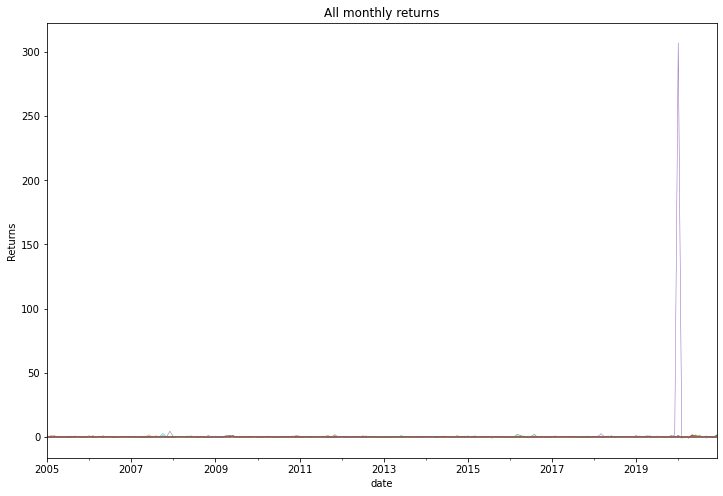

In [39]:
# Define the plot (plot all lines)
ax = nrg_returns.plot(linewidth=0.5, figsize=(12,8))
ax.get_legend().remove()
# Title
ax.set_title('All monthly returns')
# ylabel
ax.set_ylabel('Returns');

In [40]:
outlier_threshold = 10
outlier_companies = nrg_returns.loc[:, nrg_returns[(nrg_returns > outlier_threshold)].any(axis = 0)]
outlier_list = outlier_companies.columns.values.tolist()
outlier_list

['IE00BLNN3691']

In [41]:
if outlier_list[0] in nrg_returns.columns.values.tolist():
  nrg_returns = nrg_returns.drop(columns=outlier_list)
else:
  pass
  
nrg_returns

,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,-0.016535,...,-0.106096,NaN,-0.031204,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,-0.068279,...,0.150111,NaN,0.161942,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,0.122907,...,0.057778,NaN,0.080660,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,0.000000,...,0.040317,NaN,0.107051,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,-0.062137,...,0.123802,NaN,-0.066758,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,0.292894,...,0.079365,0.0,0.000000,-0.040000,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,-0.132470,...,-0.022058,0.0,0.000000,-0.020833,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,-0.097708,...,-0.146617,0.0,0.000000,-0.021277,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972


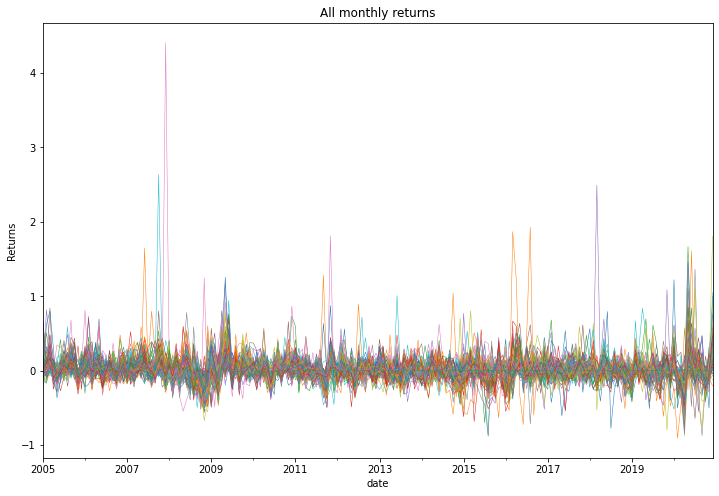

In [42]:
# Define the plot (plot all lines)
ax = nrg_returns.plot(linewidth=0.5, figsize=(12,8))
ax.get_legend().remove()
# Title
ax.set_title('All monthly returns')
# ylabel
ax.set_ylabel('Returns');

In [43]:
nrg_assets = nrg_returns.columns.values.tolist()

## Get market caps

In [44]:
df_caps = pd.read_excel("https://github.com/GuillaumeR16/financelecture/blob/main/size.xlsx?raw=true")
df_caps = df_caps.rename(columns={"Unnamed: 0": "date"})
df_caps

,date,AEA000201011,AEA001501013,AEA002001013,AED000201015,AED000601016,AED000901010,AED001301012,AED001501017,AEDFXA0M6V00,...,ZAE000216537,ZAE000221370,ZAE000248498,ZAE000248506,ZAE000255360,ZAE000255915,ZAE000259479,ZAE000259701,ZAE000265971,ZAE000269890
0,2007-01-31,6534700000,758897000.0,1859940000,6350640000,2305090000,NaN,NaN,NaN,NaN,...,NaN,2.072570e+09,NaN,NaN,18552700000,12380100000,NaN,NaN,NaN,1.237120e+09
1,2007-02-28,6611120000,751838000.0,2235750000,6503290000,2391120000,NaN,NaN,NaN,NaN,...,NaN,1.966200e+09,NaN,NaN,19039600000,12764800000,NaN,NaN,NaN,1.233470e+09
2,2007-03-31,5980720000,838744000.0,1940260000,5319980000,2506660000,NaN,NaN,NaN,NaN,...,NaN,2.143880e+09,NaN,NaN,16878100000,12948100000,NaN,NaN,NaN,1.202500e+09
3,2007-04-30,6534350000,714754000.0,2329490000,6060680000,2630020000,NaN,NaN,NaN,NaN,...,NaN,2.478330e+09,NaN,NaN,18710200000,13936100000,NaN,NaN,NaN,1.401440e+09
4,2007-05-31,7647060000,923382000.0,3405840000,8077450000,2808010000,NaN,NaN,NaN,NaN,...,NaN,2.277380e+09,NaN,NaN,17881000000,12799400000,NaN,NaN,NaN,1.362000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2020-08-31,10494400000,NaN,4345770000,8082950000,1412400000,1.888480e+09,1.447930e+09,261378000.0,1.347090e+10,...,5.543370e+09,NaN,1.007220e+09,1.007220e+09,3111030000,3866810000,2.096430e+09,NaN,2.531580e+09,1.340430e+09
164,2020-09-30,10702800000,NaN,4302950000,8516670000,1331360000,1.825310e+09,1.517110e+09,291872000.0,1.347090e+10,...,5.176610e+09,NaN,1.027260e+09,1.027260e+09,2915080000,4525010000,2.436750e+09,NaN,2.561640e+09,1.387060e+09
165,2020-10-31,11119500000,NaN,5865720000,8201230000,1319780000,1.823130e+09,1.795500e+09,250487000.0,1.347090e+10,...,4.598340e+09,NaN,1.037060e+09,1.037060e+09,2718960000,4536810000,2.692790e+09,NaN,3.649600e+09,1.198440e+09
166,2020-11-30,11517300000,NaN,6507950000,8832100000,1447130000,1.901550e+09,1.943750e+09,250487000.0,1.347090e+10,...,6.058280e+09,NaN,1.178770e+09,1.178770e+09,3558920000,6040410000,3.266010e+09,NaN,3.722370e+09,1.528570e+09


In [45]:
returns_isin = nrg_returns.columns.values.tolist()
nrg_caps = df_caps[df_returns.columns.intersection(returns_isin)]
nrg_caps

,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
0,74825700000,5.135480e+08,3079170000,6.037320e+09,3.372720e+09,NaN,3.423190e+09,1555140000,3010950000,2.424230e+09,...,6471650000,1.646810e+10,7.660140e+09,NaN,4416550000,32791300000,16095200000,1.846830e+10,18410400000,2.134640e+10
1,74012500000,5.645100e+08,3678900000,6.068140e+09,3.591960e+09,NaN,4.794950e+09,1587330000,3043510000,2.304480e+09,...,6610540000,1.622220e+10,7.819090e+09,NaN,4562190000,34760700000,16124300000,1.899390e+10,17123300000,2.019070e+10
2,81437400000,7.861750e+08,4286560000,6.333870e+09,3.940580e+09,NaN,5.134680e+09,1766810000,3141950000,2.416050e+09,...,6929820000,1.658860e+10,8.547130e+09,NaN,4287570000,38959300000,17015200000,2.016770e+10,16507100000,2.090860e+10
3,87013400000,8.771610e+08,3995060000,6.589470e+09,4.171120e+09,NaN,5.220020e+09,1770770000,3144040000,2.155100e+09,...,7135780000,1.648120e+10,9.173000e+09,NaN,4208900000,38555600000,17666300000,1.999130e+10,16494200000,2.173170e+10
4,91774800000,1.210180e+09,3620750000,6.334960e+09,4.341900e+09,NaN,5.632360e+09,1949750000,3636350000,2.562450e+09,...,8087210000,1.682560e+10,9.680650e+09,NaN,4125110000,40965700000,19019700000,2.137570e+10,16691800000,2.271890e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,26387800000,NaN,476420000,7.273810e+09,2.467690e+08,7.037400e+08,3.692620e+09,2007750000,1243010000,NaN,...,1683270000,NaN,NaN,818854000.0,10271300000,21444000000,25193500000,NaN,3844310000,5.154680e+09
164,21660000000,NaN,396511000,5.423190e+09,1.815220e+08,7.678170e+08,3.559380e+09,1947860000,1041240000,NaN,...,1423030000,NaN,NaN,811556000.0,9602990000,17664000000,23846400000,NaN,2667690000,4.877320e+09
165,20796900000,NaN,389036000,4.949720e+09,1.852240e+08,7.726980e+08,3.452640e+09,1605490000,959765000,NaN,...,1616840000,NaN,NaN,729863000.0,9199600000,15744700000,23288700000,NaN,2562820000,3.275830e+09
166,28940300000,NaN,420255000,6.700900e+09,2.234230e+08,1.004980e+09,4.946650e+09,1730840000,969609000,NaN,...,2092300000,NaN,NaN,932591000.0,11328700000,21926800000,25461000000,NaN,3702360000,4.933380e+09


In [46]:
# date as index
if 'date' in nrg_caps.columns.values.tolist():
  nrg_caps.set_index("date", inplace=True)
else:
  pass

# count NANs
nrg_returns.isnull().sum().sum()

526

# Answering HW questions

## Q1

**Compute and report the annualized average return and annualized volatility for all individual assets over the period 2005-2020. Compute the correlation between individual
average returns and volatility and comment on the observed correlation. (10 points)**

Compute the correlation between either average returns all together and volatility all together, but also between both metrics.

In [47]:
# annualized average return:
# for each asset, take the average monthly return over all monthly observations
# then multiply by 12 to get annualized average return

# annualized volatility:
# for each asset take the standard deviation over all monthly observations and multiply by the square root of 12

In [48]:
df_q1 = pd.DataFrame([])

for a in nrg_returns.columns.values.tolist():

  # get annualized average return
  avg_monthly = nrg_returns[a].mean()
  annualized_avg_return = avg_monthly*12

  # get annualized volatility
  std_monthly = nrg_returns[a].std()
  annualized_volatility = std_monthly*math.sqrt(12)

  # create series
  asset = {'AAR':annualized_avg_return, 'volatility': annualized_volatility}
  series = pd.Series(data=asset, index=['AAR', 'volatility'])

  # concat
  df_q1 = pd.concat([df_q1, series.rename(a)], axis=1)

# transpose df for readability
df_q1 = df_q1.T

# show
df_q1.head()

,AAR,volatility
AN8068571086,0.070937,0.372584
AU000000AOE6,0.233029,0.423224
AU000000ERA9,-0.016714,0.561325
AU000000ORG5,0.087845,0.368280
AU000000PDN8,0.277071,0.972955


In [49]:
df_q1.describe()

,AAR,volatility
count,185.000000,185.000000
mean,0.114505,0.440064
std,0.103810,0.155904
min,-0.244423,0.155693
25%,0.067506,0.347150
50%,0.111135,0.420355
75%,0.167964,0.508374
max,0.452643,1.243948


<Axes: >

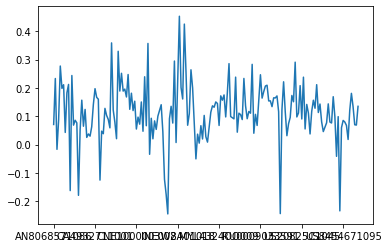

In [50]:
df_q1['AAR'].plot()

In [51]:
df_q1.loc[df_q1['AAR'] >= 15]

,AAR,volatility


<Axes: >

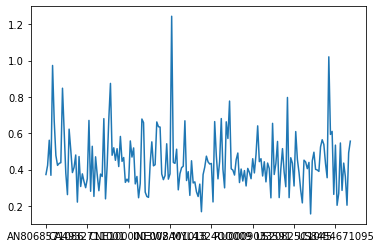

In [52]:
df_q1['volatility'].plot()

In [53]:
df_q1.loc[df_q1['volatility'] >= 15]

,AAR,volatility


In [54]:
nrg_returns['AU000000ERA9'].describe()

count    192.000000
mean      -0.001393
std        0.162041
min       -0.697007
25%       -0.087002
50%       -0.016616
75%        0.073296
max        0.681818
Name: AU000000ERA9, dtype: float64

In [55]:
# verify that this is correct by manually doing the same for the 2nd asset

# AAR
check_aar = nrg_returns['AU000000ERA9'].mean()
check_aar_annualized = check_aar*12

# volatility
check_std = nrg_returns['AU000000ERA9'].std()
check_std_annualized = check_std*math.sqrt(12)

print(check_aar_annualized)
print(check_std_annualized)

-0.016714158087070413
0.5613248197424915


In [56]:
# correlation between individual average returns and volatility
corr_arr_vol_q1 = df_q1['AAR'].corr(df_q1['volatility'])
corr_arr_vol_q1

0.10632461758462823

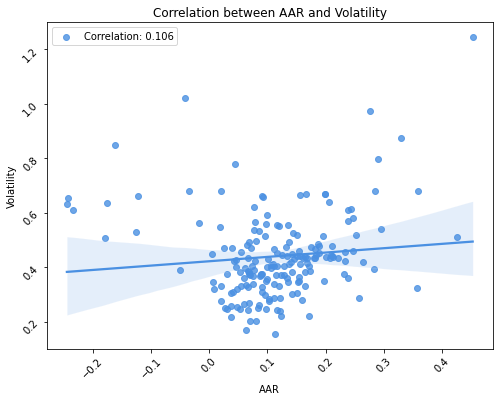

In [57]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Use the function regplot to make a scatterplot
sns.regplot(x=df_q1['AAR'], y=df_q1['volatility'], color='#4A90E2', seed=0)

# Add a title and axis labels
plt.title('Correlation between AAR and Volatility')
plt.xlabel('AAR')
plt.ylabel('Volatility')

# Customize the tick marks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.legend(labels=[f'Correlation: {round(corr_arr_vol_q1, 3)}'])

# Change the background color
sns.set_style("whitegrid")

plt.show()

## Q2

**Form an equally-weighted and value-weighted portfolio with monthly rebalancing over
the period 2005-2020. Report the following statistics for both portfolios: annualized
average return, annualized volatility, minimum return, maximum return, and Sharpe
ratio. Plot the time series of returns for both portfolios. (15 points)**

In [58]:
risk_free_rate = 0.035

### Build Q2 df

In [59]:
# build melted df with market caps

df_q2 = nrg_returns_date_column.drop(columns=['IE00BLNN3691'])
df_q2 = df_q2.melt(id_vars =['date'], var_name='ISIN', value_name='monthly_return')

df_q2['date'] = pd.to_datetime(df_q2['date'], infer_datetime_format=True)
df_q2['year'] = df_q2.date.dt.year
df_q2['month'] = df_q2.date.dt.month
df_q2 = df_q2[['date','year','month','ISIN','monthly_return']].copy()

df_size = df_caps.melt(id_vars =['date'], var_name='ISIN', value_name='market_cap')
df_q2 = pd.merge(df_q2, df_size, how='left', on=('date','ISIN'))

df_q2

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN
...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09


In [60]:
#Annual return (sum of monthly returns per year per ISIN)
an_rtrn = df_q2[['year','ISIN','monthly_return']].groupby(['year', 'ISIN']).sum().copy()

def annual_return(row):
    ISIN = row['ISIN']
    year = row['year']
    return an_rtrn.loc[(year,ISIN)][0]

df_q2['annual_returns'] = df_q2.apply(annual_return, axis=1)
df_q2

,date,year,month,ISIN,monthly_return,market_cap,annual_returns
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026
...,...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09,1.030514
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09,1.030514
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09,1.030514
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09,1.030514


### Equally-weighted portfolio

In [61]:
# build equally weighted portfolio with monthly rebalancing
df_q2_e = df_q2.copy()

num_assets = len(df_q2_e.columns.values.tolist())
equal_weight = 1 / num_assets
df_q2_e.head(2)

,date,year,month,ISIN,monthly_return,market_cap,annual_returns
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026


In [62]:
#Computing the AAR of the equally-weighted portfolio for the 15years under observation
AAR = df_q2_e[['ISIN','monthly_return']].groupby('ISIN').apply(lambda x: x.mean()*12).copy()
def AAR_func(row):
    ISIN = row['ISIN']
    return AAR.loc[(ISIN)][0]
df_q2_e['ew_AAR'] = df_q1.AAR.mean()

df_q2_e['ew_annualized_volatility'] = df_q2_e.monthly_return.std()*math.sqrt(12)

#Computing the annual return of the equally-weighted portolio
eq_weight_port_df = df_q2_e[['year','annual_returns']].groupby('year').mean()
def eq_weight_port_func(row):
    year = row['year']
    return eq_weight_port_df.loc[year][0]
df_q2_e['ew_annual_return']= df_q2_e.apply(eq_weight_port_func, axis=1)

#computing the monthly return of the value-weighted portfolio 
ew_monthly_return_df = df_q2_e[['year','month','monthly_return']].groupby(['year','month']).sum()
def ew_monthly_return_func(row):
    year = row['year']
    month = row['month']
    return ew_monthly_return_df.loc[(year,month)][0]
df_q2_e['ew_monthly_return'] = df_q2_e.apply(ew_monthly_return_func, axis=1)

#computing portfolio statistics
ew_min = df_q2_e['ew_annual_return'].min()
ew_max = df_q2_e['ew_annual_return'].max()
ew_sharperatio = (df_q2_e['ew_AAR'].mean() - risk_free_rate)/df_q2_e['ew_annualized_volatility'].mean()
#showing dataframe
df_q2_e[190:196]

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,ew_AAR,ew_annualized_volatility,ew_annual_return,ew_monthly_return
190,2020-11-30,2020,11,AN8068571086,0.037976,2.894030e+10,-0.099189,0.114505,0.466141,0.046559,-1.584512
191,2020-12-31,2020,12,AN8068571086,0.360397,3.039450e+10,-0.099189,0.114505,0.466141,0.046559,44.347042
192,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN,0.726672,0.114505,0.466141,0.404962,2.173506
193,2005-02-28,2005,2,AU000000AOE6,-0.006316,NaN,0.726672,0.114505,0.466141,0.404962,9.533271
194,2005-03-31,2005,3,AU000000AOE6,0.131431,NaN,0.726672,0.114505,0.466141,0.404962,18.887986
195,2005-04-30,2005,4,AU000000AOE6,-0.053780,NaN,0.726672,0.114505,0.466141,0.404962,0.080955


In [63]:
ew_AAR = df_q2_e['ew_AAR'].mean()
ew_volatility = df_q2_e['ew_annualized_volatility'].mean()

print(f'Equally-weighted portfolio statistics:\n\nAAR: {ew_AAR}')
print(f'Max yearly return: {ew_max}')
print(f'Min yearly return: {ew_min}')
print(f'Sharpe ratio: {ew_sharperatio}')
print(f'Annualized volatility: {ew_volatility}')

Equally-weighted portfolio statistics:

AAR: 0.11450456815375405
Max yearly return: 0.7621268239197497
Min yearly return: -0.6012519031706335
Sharpe ratio: 0.1705590476162641
Annualized volatility: 0.466141018403369


### Value-weighted portfolio

In [64]:
# build equally weighted portfolio with monthly rebalancing
df_q2_v = df_q2.copy()
df_q2_v.head()

,date,year,month,ISIN,monthly_return,market_cap,annual_returns
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026


In [65]:
# get monthly total market value
val_weight_df = df_q2_v[['year','month','market_cap']].groupby(['year','month']).sum().copy()

# function to get value-based weights
def val_weight_func(row):
    year = row['year']
    month = row['month']
    return row['market_cap']/val_weight_df.loc[(year,month)][0]

In [66]:
df_q2_v['value_weight'] = df_q2_v.apply(val_weight_func, axis=1)
df_q2_v

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,value_weight
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026,NaN
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026,NaN
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026,NaN
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026,NaN
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026,NaN
...,...,...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09,1.030514,0.002621
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09,1.030514,0.002824
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09,1.030514,0.001902
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09,1.030514,0.002382


In [67]:
#computing the monthly returns for each ISIN based on the market cap weight per month
df_q2_v['vw_asset_monthly_weighted_returns'] = df_q2_v['monthly_return']*df_q2_v['value_weight']

#computing the AAR of the value-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 16 years of data
df_q2_v['vw_AAR'] = (df_q2_v['vw_asset_monthly_weighted_returns'].sum())/16

#computing the annual returns of the value-weighted portfolio 
vw_annual_return_df = df_q2_v[['year','vw_asset_monthly_weighted_returns']].groupby('year').sum()
def vw_annual_return_func(row):
    year = row['year']
    return vw_annual_return_df.loc[(year)][0]
df_q2_v['vw_annual_return'] = df_q2_v.apply(vw_annual_return_func, axis=1)

#computing the monthly return of the value-weighted portfolio 
vw_monthly_return_df = df_q2_v[['year','month','vw_asset_monthly_weighted_returns']].groupby(['year','month']).sum()
def vw_monthly_return_func(row):
    year = row['year']
    month = row['month']
    return vw_monthly_return_df.loc[(year,month)][0]
df_q2_v['vw_monthly_return'] = df_q2_v.apply(vw_monthly_return_func, axis=1)

#computing portfolio statistics
df_q2_v['vw_annualized_volatility'] = df_q2_v['vw_monthly_return'].std()*math.sqrt(12)
vw_min = df_q2_v['vw_annual_return'].min()
vw_max = df_q2_v['vw_annual_return'].max()
vw_sharperatio = (df_q2_v['vw_annual_return'].mean() - risk_free_rate)/df_q2_v['vw_annualized_volatility'].mean()
#showing dataframe
df_q2_v

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,value_weight,vw_asset_monthly_weighted_returns,vw_AAR,vw_annual_return,vw_monthly_return,vw_annualized_volatility
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09,1.030514,0.002621,0.000216,0.06779,-0.074265,-0.003596,0.226115
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09,1.030514,0.002824,0.000102,0.06779,-0.074265,0.017528,0.226115
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09,1.030514,0.001902,-0.000184,0.06779,-0.074265,-0.108465,0.226115
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09,1.030514,0.002382,-0.000693,0.06779,-0.074265,-0.014693,0.226115


In [68]:
vw_AAR = df_q2_v['vw_AAR'].mean()
vw_volatility = df_q2_v['vw_annualized_volatility'].mean()

print(f'Value-weighted portfolio statistics:\n\nAAR: {vw_AAR}')
print(f'Max yearly return: {vw_max}')
print(f'Min yearly return: {vw_min}')
print(f'Sharpe ratio: {vw_sharperatio}')
print(f'Annualized volatility: {vw_volatility}')

Value-weighted portfolio statistics:

AAR: 0.06779019808547349
Max yearly return: 0.5026170333602856
Min yearly return: -0.45433048217973254
Sharpe ratio: 0.14501542474084794
Annualized volatility: 0.2261152435616536


### Comparison: plots and table

In [69]:
# Generate sample data
x = df_q2.groupby('year').year.mean()
y1 = df_q2_v.groupby('year').vw_annual_return.mean()
#y2 = df_q2_v.groupby(['year','month']).vw_monthly_return.mean()
y3 = df_q2_e.groupby('year').ew_annual_return.mean()
#y4 = df_q2_e.groupby(['year','month']).ew_monthly_return.mean()

# Create figure
fig = go.Figure()

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1, name='Value-weighted portfolio annual returns', line=dict(color='lightblue', width=5)))
#fig.add_trace(go.Scatter(x=x, y=y2, name='Value-weighted portfolio monthly returns', line=dict(color='lightblue', width=2)))
fig.add_trace(go.Scatter(x=x, y=y3, name='Equally-weighted portfolio annual returns', line=dict(color='darkgreen', width=5)))
#fig.add_trace(go.Scatter(x=x, y=y4, name='Equally-weighted portfolio monthly returns', line=dict(color='darkgreen', width=2)))

# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=16),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=18), side='top')),
                  legend_title_font=dict(size=18),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year', font=dict(size=22), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()

Really high numbers in 2009! See https://www.naturalgasintel.com/2009-called-terrific-year-for-energy-investors-2/

In [70]:
# Create a new table
table = prettytable.PrettyTable()

# Add the columns to the table
table.field_names = ['Portfolio','Value-weighted portfolio','Equally-weighted portfolio']

# Add the rows to the table
tabledf={
    'Annualized average return': ['Annualized average return',round(vw_AAR,4),round(ew_AAR,4)],
    'Annualized Volatility': ['Annualized volatility',round(vw_volatility,4),round(ew_volatility,4)],
    'Minimum return': ['Minimum return',round(vw_min,4),round(ew_min,4)],
    'Maximum return': ['Maximum return',round(vw_max,4),round(ew_max,4)],
    'Sharpe Ratio': ['Sharpe Ratio',round(vw_sharperatio,4),round(ew_sharperatio,4)]
}

for row in tabledf:
    table.add_row(tabledf[row])

# Add borders to the table
table.hrules = prettytable.ALL
table.header = True
table.set_style(prettytable.SINGLE_BORDER)

# Save the table to a file
with open('value&equal.txt', 'w') as f:
    f.write(str(table))
    
# Display the table
print(table)

┌───────────────────────────┬──────────────────────────┬────────────────────────────┐
│         Portfolio         │ Value-weighted portfolio │ Equally-weighted portfolio │
├───────────────────────────┼──────────────────────────┼────────────────────────────┤
│ Annualized average return │          0.0678          │           0.1145           │
├───────────────────────────┼──────────────────────────┼────────────────────────────┤
│   Annualized volatility   │          0.2261          │           0.4661           │
├───────────────────────────┼──────────────────────────┼────────────────────────────┤
│       Minimum return      │         -0.4543          │          -0.6013           │
├───────────────────────────┼──────────────────────────┼────────────────────────────┤
│       Maximum return      │          0.5026          │           0.7621           │
├───────────────────────────┼──────────────────────────┼────────────────────────────┤
│        Sharpe Ratio       │          0.145          

## Q3

**For this question, limit your set of firms to 100 randomly selected firms. Pay a particular
attention to the construction of the covariance matrix.**

**Build an optimal portfolio with
minimum variance with monthly rebalancing over the period 2005-2020. Report the
following statistics: annualized average return, annualized volatility, minimum return,
maximum return, and Sharpe ratio. Comment on the reported statistics in comparison
with the equally-weighted and value-weighted portfolio. (20 points)**

"To to avoid any confusion on the rolling window approach to estimate the covariance matrix with Python: for monthly returns, to estimate 10-year covariance matrices, the window size should be equal to 12*10=120, df.rolling(window=120).cov()."

### Build Q3 df

In [71]:
nrg_returns_date_column.head()

,date,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
36,2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,...,-0.106096,NaN,-0.031204,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
37,2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,...,0.150111,NaN,0.161942,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
38,2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,...,0.057778,NaN,0.080660,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
39,2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,...,0.040317,NaN,0.107051,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
40,2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,...,0.123802,NaN,-0.066758,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448


In [72]:
df_q3 = nrg_returns_date_column.drop(columns=['IE00BLNN3691'])
df_q3 = df_q3.melt(id_vars =['date'], var_name='ISIN', value_name='monthly_return')


df_q3['date'] = pd.to_datetime(df_q3['date'], infer_datetime_format=True)
df_q3['year'] = df_q3.date.dt.year
df_q3['month'] = df_q3.date.dt.month
df_q3 = df_q3[['date','year','month','ISIN','monthly_return']].copy()

df_q3

,date,year,month,ISIN,monthly_return
0,2005-01-31,2005,1,AN8068571086,0.012603
1,2005-02-28,2005,2,AN8068571086,0.063502
2,2005-03-31,2005,3,AN8068571086,0.093039
3,2005-04-30,2005,4,AN8068571086,-0.038401
4,2005-05-31,2005,5,AN8068571086,-0.027085
...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327
35516,2020-09-30,2020,9,ZAE000006896,0.036017
35517,2020-10-31,2020,10,ZAE000006896,-0.096972
35518,2020-11-30,2020,11,ZAE000006896,-0.291075


In [73]:
df_size = df_caps.melt(id_vars =['date'], var_name='ISIN', value_name='market_cap')
df_size
df_q3 = pd.merge(df_q3, df_size, how='left', on=('date','ISIN'))
df_q3

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN
...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09


In [74]:
unique_assets = df_q3.ISIN.unique()
print(len(unique_assets))
print(len(df_q3.ISIN) / len(unique_assets))

185
192.0


In [75]:
df_nona = nrg_returns[nrg_returns.columns[~nrg_returns.isnull().any()]]
print(df_nona.isnull().sum().sum())
nona_assets = df_nona.columns.values.tolist()
df_nona.head()

0


,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,BRUGPAACNOR8,...,US78532P1075,US8321101003,US8454671095,US86764P1093,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,0.053326,-0.221404,-0.000471,-0.016535,0.018039,...,-0.088156,-0.086143,-0.106096,-0.031204,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,0.037500,0.031757,-0.012241,-0.068279,0.022781,...,0.114714,0.138451,0.150111,0.161942,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,0.130329,0.230611,0.163489,0.122907,0.039161,...,0.167271,0.047169,0.057778,0.080660,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,0.049456,0.038771,0.140516,0.000000,-0.018633,...,0.061425,0.015205,0.040317,0.107051,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,0.004279,0.031982,0.000359,-0.062137,0.054247,...,-0.048808,-0.054704,0.123802,-0.066758,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448


In [76]:
# randomly select 100 firms
randfirms = random .sample(nona_assets, 100)

In [77]:
df_q3_100 = df_q3[df_q3.ISIN.isin(randfirms) == True]
df_q3_100.head()

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN


In [78]:
df_q3_100_sorted = df_q3_100.sort_values(by=['date','ISIN'], inplace = False) 
df_q3_100_sorted = df_q3_100_sorted.reset_index(drop=True)
df_q3_100_sorted

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-01-31,2005,1,ARP9897X1319,0.028704,NaN
2,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN
3,2005-01-31,2005,1,AU000000PDN8,-0.058855,NaN
4,2005-01-31,2005,1,AU000000WOR2,0.053326,NaN
...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN


In [79]:
df_q3_ret = nrg_returns.drop(columns=[col for col in nrg_returns if col not in randfirms])

df_q3_ret = nrg_returns.drop(columns=[col for col in nrg_returns if col not in randfirms])
df_q3_ret = df_q3_ret[df_q3_100_sorted.ISIN.unique().tolist()]

df_q3_ret

,AN8068571086,ARP9897X1319,AU000000AOE6,AU000000PDN8,AU000000WOR2,BMG2108M2182,BMG5320C1082,CA00208D4084,CA07317Q1054,CA13321L1085,...,US7265051000,US78532P1075,US8321101003,US8454671095,US86764P1093,US9026531049,US91913Y1001,US9694571004,US98385X1063,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.012603,0.028704,-0.087586,-0.058855,0.053326,-0.000471,-0.016535,0.040247,-0.034085,0.041354,...,-0.088714,-0.088156,-0.086143,-0.106096,-0.031204,0.047824,-0.035393,-0.046450,-0.060108,0.088215
2005-02-28,0.063502,0.094693,-0.006316,0.818187,0.037500,-0.012241,-0.068279,0.068301,0.031087,0.022812,...,0.162622,0.114714,0.138451,0.150111,0.161942,-0.069058,0.322805,0.092083,0.108183,-0.087507
2005-03-31,0.093039,0.258207,0.131431,0.373450,0.130329,0.163489,0.122907,-0.021335,0.106992,0.228900,...,0.167055,0.167271,0.047169,0.057778,0.080660,-0.008869,0.196423,0.077830,0.183483,0.231228
2005-04-30,-0.038401,-0.103228,-0.053780,-0.114356,0.049456,0.140516,0.000000,0.010010,0.059772,0.023040,...,0.082056,0.061425,0.015205,0.040317,0.107051,-0.067113,0.142520,0.045476,0.067322,0.002223
2005-05-31,-0.027085,-0.011597,-0.122518,-0.006077,0.004279,0.000359,-0.062137,-0.094755,-0.114746,-0.101434,...,-0.098198,-0.048808,-0.054704,0.123802,-0.066758,0.083772,-0.118698,-0.084998,-0.109858,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.056431,0.286645,0.025929,0.221436,-0.087717,0.001988,0.292894,0.260780,-0.092319,-0.011380,...,0.000000,0.000000,0.000000,0.079365,0.000000,-0.087904,-0.027463,0.048380,0.000000,0.082327
2020-09-30,0.001871,-0.143275,0.038956,0.412873,0.253637,-0.034939,-0.132470,0.196934,0.061839,0.140574,...,0.000000,0.000000,0.000000,-0.022058,0.000000,-0.014810,-0.026711,0.062879,0.000000,0.036017
2020-10-31,-0.194313,-0.258657,-0.026587,-0.255603,-0.000491,-0.147194,-0.097708,-0.116689,-0.318008,-0.150104,...,0.000000,0.000000,0.000000,-0.146617,0.000000,-0.023121,-0.232324,-0.086246,0.000000,-0.096972


### Previous tries with monthly cov mat

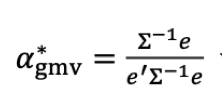

### Only one covmat

### Rolling covariance matrices and weight computation

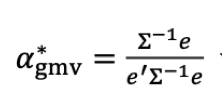

In [88]:
df_q3_ret_2015 = df_q3_ret[-72:]
df_q3_ret_2015 = df_q3_ret_2015.reset_index().drop(columns = ['date'])
df_q3_ret_2015

,AN8068571086,ARP9897X1319,AU000000AOE6,AU000000PDN8,AU000000WOR2,BMG2108M2182,BMG5320C1082,CA00208D4084,CA07317Q1054,CA13321L1085,...,US7265051000,US78532P1075,US8321101003,US8454671095,US86764P1093,US9026531049,US91913Y1001,US9694571004,US98385X1063,ZAE000006896
0,0.006719,-0.164872,-0.036267,0.101381,-0.032755,0.231498,-0.075595,-0.045357,-0.161982,-0.092296,...,0.0,-0.616708,0.0,-0.125321,0.0,0.003582,0.012271,-0.092288,0.0,-0.048359
1,-0.009015,-0.100522,-0.044492,-0.017961,-0.084883,0.035793,0.099828,-0.120860,0.038085,-0.080803,...,0.0,-0.012821,0.0,-0.048736,0.0,0.088614,0.099797,-0.002447,0.0,0.047431
2,0.005589,0.044975,-0.004725,0.035626,0.026536,-0.036665,-0.043730,0.033370,-0.083643,-0.002608,...,0.0,0.220779,0.0,-0.038134,0.0,-0.028237,0.085618,0.093687,0.0,-0.095608
3,-0.004019,0.095382,-0.021014,-0.046419,-0.062021,0.027508,-0.025691,-0.105240,0.032368,-0.057268,...,0.0,-0.680851,0.0,-0.084502,0.0,0.042973,0.081473,0.033609,0.0,-0.035505
4,0.103465,0.056425,0.028333,-0.026493,0.269466,-0.018012,0.229473,0.182898,0.201626,0.213932,...,0.0,-0.216667,0.0,0.258967,0.0,-0.014832,-0.071710,0.021577,0.0,0.194198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.056431,0.286645,0.025929,0.221436,-0.087717,0.001988,0.292894,0.260780,-0.092319,-0.011380,...,0.0,0.000000,0.0,0.079365,0.0,-0.087904,-0.027463,0.048380,0.0,0.082327
68,0.001871,-0.143275,0.038956,0.412873,0.253637,-0.034939,-0.132470,0.196934,0.061839,0.140574,...,0.0,0.000000,0.0,-0.022058,0.0,-0.014810,-0.026711,0.062879,0.0,0.036017
69,-0.194313,-0.258657,-0.026587,-0.255603,-0.000491,-0.147194,-0.097708,-0.116689,-0.318008,-0.150104,...,0.0,0.000000,0.0,-0.146617,0.0,-0.023121,-0.232324,-0.086246,0.0,-0.096972
70,0.037976,-0.083209,-0.019773,-0.095238,-0.061808,-0.106459,-0.011904,0.132537,0.002247,-0.031907,...,0.0,0.000000,0.0,0.215860,0.0,-0.020107,-0.009433,-0.000533,0.0,-0.291075


In [ ]:
# get covariance matrices over 10 years windows & select those from Jan 2015 to Dec 2020
cov_mats = df_q3_ret.rolling(window=120).cov().iloc[12000:]

In [90]:
# optimal min var weights

min_var_weights = []

for m in range(len(df_q3_ret_2015)):

  cov_start = m*100
  cov_end = cov_start + 100

  cov_mat = cov_mats[cov_start:cov_end]

  inv_cov = np.linalg.inv(cov_mat)

  returns = df_q3_ret_2015.iloc[m]

  def objective(weights, cov_mat):
      return weights.T @ cov_mat @ weights

  def constraint1(weights):
      return np.sum(weights) - 1

  constraints = [{'type': 'eq', 'fun': constraint1}]

  bounds = tuple((0, 1) for x in range(len(returns)))

  weights = np.ones(len(returns)) / len(returns)

  result = minimize(objective, weights, args=cov_mat, constraints=constraints, bounds=bounds)

  month_weights = result.x / np.sum(result.x)

  month_weights = list(month_weights)

  min_var_weights.append(month_weights)

In [91]:
print(len(min_var_weights))
print(type(min_var_weights))
#min_var_weights

72
<class 'list'>


In [92]:
df_min_var_weights = pd.DataFrame()

for i in range(len(min_var_weights)):
  
  month_weights = pd.Series(min_var_weights[i])
  df_min_var_weights = pd.concat([df_min_var_weights, month_weights], ignore_index=True)
  
df_min_var_weights.columns.values[0] = "min_var_weights"
df_min_var_weights

,min_var_weights
0,0.000000e+00
1,7.263826e-18
2,1.667753e-18
3,0.000000e+00
4,0.000000e+00
...,...
7195,4.177614e-18
7196,0.000000e+00
7197,6.720269e-19
7198,2.219864e-01


In [94]:
#month_weights_list[5]

### Adding weights to DF

In [100]:
df_q3_100_sorted.head()

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-01-31,2005,1,ARP9897X1319,0.028704,NaN
2,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN
3,2005-01-31,2005,1,AU000000PDN8,-0.058855,NaN
4,2005-01-31,2005,1,AU000000WOR2,0.053326,NaN


In [101]:
df_q3_100_sorted_2015 = df_q3_100_sorted[-7200:].reset_index()

In [103]:
df_q3_100_sorted_2015['mv_weights'] = df_min_var_weights.min_var_weights

In [104]:
df_q3_100_sorted_2015

,index,date,year,month,ISIN,monthly_return,market_cap,mv_weights
0,12000,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,0.000000e+00
1,12001,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,7.263826e-18
2,12002,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN,1.667753e-18
3,12003,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08,0.000000e+00
4,12004,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09,0.000000e+00
...,...,...,...,...,...,...,...,...
7195,19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,4.177614e-18
7196,19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,0.000000e+00
7197,19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,6.720269e-19
7198,19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,2.219864e-01


### Computing required metrics

In [105]:
#computing the monthly returns for each ISIN based on the market cap weight per month
df_q3_100_sorted_2015['mv_assets_monthly_weighted_returns'] = df_q3_100_sorted_2015['monthly_return']*df_q3_100_sorted_2015['mv_weights']

#computing the AAR of the minvar-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 6 years of data
df_q3_100_sorted_2015['mv_AAR'] = (df_q3_100_sorted_2015['mv_assets_monthly_weighted_returns'].sum())/6

#computing the annual return of the value-weighted portfolio 
annual_return_df = df_q3_100_sorted_2015[['year','mv_assets_monthly_weighted_returns']].groupby('year').sum()
def annual_return_func(row):
    year = row['year']
    return annual_return_df.loc[(year)][0]
df_q3_100_sorted_2015['mv_annual_return'] = df_q3_100_sorted_2015.apply(annual_return_func, axis=1)

#computing the monthly return of the value-weighted portfolio 
monthly_returns_df = df_q3_100_sorted_2015[['year','month','mv_assets_monthly_weighted_returns']].groupby(['year','month']).sum()

def monthly_returns_func(row):
    year = row['year']
    month = row['month']
    return monthly_returns_df.loc[(year,month)][0]

df_q3_100_sorted_2015['mv_monthly_returns'] = df_q3_100_sorted_2015.apply(monthly_returns_func, axis=1)

# computing portfolio volatility
df_q3_100_sorted_2015['mv_annualized_volatility'] = df_q3_100_sorted_2015['mv_monthly_returns'].std()*math.sqrt(12)

df_q3_100_sorted_2015

,index,date,year,month,ISIN,monthly_return,market_cap,mv_weights,mv_assets_monthly_weighted_returns,mv_AAR,mv_annual_return,mv_monthly_returns,mv_annualized_volatility
0,12000,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,0.000000e+00,0.000000e+00,0.047346,0.034440,0.008027,0.065172
1,12001,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,7.263826e-18,-1.197602e-18,0.047346,0.034440,0.008027,0.065172
2,12002,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN,1.667753e-18,-6.048462e-20,0.047346,0.034440,0.008027,0.065172
3,12003,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08,0.000000e+00,0.000000e+00,0.047346,0.034440,0.008027,0.065172
4,12004,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09,0.000000e+00,-0.000000e+00,0.047346,0.034440,0.008027,0.065172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,4.177614e-18,7.440492e-19,0.047346,0.018606,0.004410,0.065172
7196,19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,0.000000e+00,0.000000e+00,0.047346,0.018606,0.004410,0.065172
7197,19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,6.720269e-19,7.626065e-20,0.047346,0.018606,0.004410,0.065172
7198,19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,2.219864e-01,0.000000e+00,0.047346,0.018606,0.004410,0.065172


In [106]:
# other statistics
mv_min = df_q3_100_sorted_2015['mv_annual_return'].min()
mv_max = df_q3_100_sorted_2015['mv_annual_return'].max()
mv_sharperatio = (df_q3_100_sorted_2015['mv_AAR'].mean() - risk_free_rate)/df_q3_100_sorted_2015['mv_annualized_volatility'].mean()

In [107]:
mv_AAR = (df_q3_100_sorted_2015['mv_assets_monthly_weighted_returns'].sum())/6
mv_volatility = df_q3_100_sorted_2015['mv_monthly_returns'].std()*math.sqrt(12)

print(f'AAR: {round(mv_AAR*100, 3)}%')
print(f'Annualized volatility: {round(mv_volatility*100, 3)}%')
print(f'Max yearly return: {round(mv_max*100, 3)}%')
print(f'Min yearly return: {round(mv_min*100, 3)}%')
print(f'Sharpe ratio: {round(mv_sharperatio, 3)}')

AAR: 4.735%
Annualized volatility: 6.517%
Max yearly return: 7.906%
Min yearly return: 1.861%
Sharpe ratio: 0.189


### Comparison: see Q5

## Q4

In [108]:
df_q4 = df_q3.copy()
df_q4

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN
...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09


In [109]:
df_q4_100_sorted = df_q3_100_sorted.copy()
df_q4_100_sorted

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-01-31,2005,1,ARP9897X1319,0.028704,NaN
2,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN
3,2005-01-31,2005,1,AU000000PDN8,-0.058855,NaN
4,2005-01-31,2005,1,AU000000WOR2,0.053326,NaN
...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN


In [110]:
df_q4_100_sorted_2015 = df_q3_100_sorted_2015.copy()
df_q4_100_sorted_2015

,index,date,year,month,ISIN,monthly_return,market_cap,mv_weights,mv_assets_monthly_weighted_returns,mv_AAR,mv_annual_return,mv_monthly_returns,mv_annualized_volatility
0,12000,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,0.000000e+00,0.000000e+00,0.047346,0.034440,0.008027,0.065172
1,12001,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,7.263826e-18,-1.197602e-18,0.047346,0.034440,0.008027,0.065172
2,12002,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN,1.667753e-18,-6.048462e-20,0.047346,0.034440,0.008027,0.065172
3,12003,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08,0.000000e+00,0.000000e+00,0.047346,0.034440,0.008027,0.065172
4,12004,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09,0.000000e+00,-0.000000e+00,0.047346,0.034440,0.008027,0.065172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,4.177614e-18,7.440492e-19,0.047346,0.018606,0.004410,0.065172
7196,19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,0.000000e+00,0.000000e+00,0.047346,0.018606,0.004410,0.065172
7197,19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,6.720269e-19,7.626065e-20,0.047346,0.018606,0.004410,0.065172
7198,19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,2.219864e-01,0.000000e+00,0.047346,0.018606,0.004410,0.065172


In [111]:
df_q4_ret = df_q3_ret.copy()
df_q4_ret

,AN8068571086,ARP9897X1319,AU000000AOE6,AU000000PDN8,AU000000WOR2,BMG2108M2182,BMG5320C1082,CA00208D4084,CA07317Q1054,CA13321L1085,...,US7265051000,US78532P1075,US8321101003,US8454671095,US86764P1093,US9026531049,US91913Y1001,US9694571004,US98385X1063,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.012603,0.028704,-0.087586,-0.058855,0.053326,-0.000471,-0.016535,0.040247,-0.034085,0.041354,...,-0.088714,-0.088156,-0.086143,-0.106096,-0.031204,0.047824,-0.035393,-0.046450,-0.060108,0.088215
2005-02-28,0.063502,0.094693,-0.006316,0.818187,0.037500,-0.012241,-0.068279,0.068301,0.031087,0.022812,...,0.162622,0.114714,0.138451,0.150111,0.161942,-0.069058,0.322805,0.092083,0.108183,-0.087507
2005-03-31,0.093039,0.258207,0.131431,0.373450,0.130329,0.163489,0.122907,-0.021335,0.106992,0.228900,...,0.167055,0.167271,0.047169,0.057778,0.080660,-0.008869,0.196423,0.077830,0.183483,0.231228
2005-04-30,-0.038401,-0.103228,-0.053780,-0.114356,0.049456,0.140516,0.000000,0.010010,0.059772,0.023040,...,0.082056,0.061425,0.015205,0.040317,0.107051,-0.067113,0.142520,0.045476,0.067322,0.002223
2005-05-31,-0.027085,-0.011597,-0.122518,-0.006077,0.004279,0.000359,-0.062137,-0.094755,-0.114746,-0.101434,...,-0.098198,-0.048808,-0.054704,0.123802,-0.066758,0.083772,-0.118698,-0.084998,-0.109858,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.056431,0.286645,0.025929,0.221436,-0.087717,0.001988,0.292894,0.260780,-0.092319,-0.011380,...,0.000000,0.000000,0.000000,0.079365,0.000000,-0.087904,-0.027463,0.048380,0.000000,0.082327
2020-09-30,0.001871,-0.143275,0.038956,0.412873,0.253637,-0.034939,-0.132470,0.196934,0.061839,0.140574,...,0.000000,0.000000,0.000000,-0.022058,0.000000,-0.014810,-0.026711,0.062879,0.000000,0.036017
2020-10-31,-0.194313,-0.258657,-0.026587,-0.255603,-0.000491,-0.147194,-0.097708,-0.116689,-0.318008,-0.150104,...,0.000000,0.000000,0.000000,-0.146617,0.000000,-0.023121,-0.232324,-0.086246,0.000000,-0.096972


In [112]:
df_q4_ret_2015 = df_q3_ret_2015.copy()
#df_q4_ret_2015 = df_q4_ret_2015.drop(columns=['index'])
df_q4_ret_2015

,AN8068571086,ARP9897X1319,AU000000AOE6,AU000000PDN8,AU000000WOR2,BMG2108M2182,BMG5320C1082,CA00208D4084,CA07317Q1054,CA13321L1085,...,US7265051000,US78532P1075,US8321101003,US8454671095,US86764P1093,US9026531049,US91913Y1001,US9694571004,US98385X1063,ZAE000006896
0,0.006719,-0.164872,-0.036267,0.101381,-0.032755,0.231498,-0.075595,-0.045357,-0.161982,-0.092296,...,0.0,-0.616708,0.0,-0.125321,0.0,0.003582,0.012271,-0.092288,0.0,-0.048359
1,-0.009015,-0.100522,-0.044492,-0.017961,-0.084883,0.035793,0.099828,-0.120860,0.038085,-0.080803,...,0.0,-0.012821,0.0,-0.048736,0.0,0.088614,0.099797,-0.002447,0.0,0.047431
2,0.005589,0.044975,-0.004725,0.035626,0.026536,-0.036665,-0.043730,0.033370,-0.083643,-0.002608,...,0.0,0.220779,0.0,-0.038134,0.0,-0.028237,0.085618,0.093687,0.0,-0.095608
3,-0.004019,0.095382,-0.021014,-0.046419,-0.062021,0.027508,-0.025691,-0.105240,0.032368,-0.057268,...,0.0,-0.680851,0.0,-0.084502,0.0,0.042973,0.081473,0.033609,0.0,-0.035505
4,0.103465,0.056425,0.028333,-0.026493,0.269466,-0.018012,0.229473,0.182898,0.201626,0.213932,...,0.0,-0.216667,0.0,0.258967,0.0,-0.014832,-0.071710,0.021577,0.0,0.194198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.056431,0.286645,0.025929,0.221436,-0.087717,0.001988,0.292894,0.260780,-0.092319,-0.011380,...,0.0,0.000000,0.0,0.079365,0.0,-0.087904,-0.027463,0.048380,0.0,0.082327
68,0.001871,-0.143275,0.038956,0.412873,0.253637,-0.034939,-0.132470,0.196934,0.061839,0.140574,...,0.0,0.000000,0.0,-0.022058,0.0,-0.014810,-0.026711,0.062879,0.0,0.036017
69,-0.194313,-0.258657,-0.026587,-0.255603,-0.000491,-0.147194,-0.097708,-0.116689,-0.318008,-0.150104,...,0.0,0.000000,0.0,-0.146617,0.0,-0.023121,-0.232324,-0.086246,0.0,-0.096972
70,0.037976,-0.083209,-0.019773,-0.095238,-0.061808,-0.106459,-0.011904,0.132537,0.002247,-0.031907,...,0.0,0.000000,0.0,0.215860,0.0,-0.020107,-0.009433,-0.000533,0.0,-0.291075


In [113]:
len(df_q4_100_sorted_2015)

7200

In [114]:
df_q4_ret_cov = df_q4_ret[:120]
past_cov = df_q4_ret_cov.cov()

In [115]:
returns = df_q4_ret
len(returns.columns)

100

In [116]:
returns = df_q4_ret_2015
len(returns.columns)

100

### Wed

In [118]:
volatility_list = []
return_list = []
portfolio_list = []
month_cov_matrix = df_q4_ret.cov()

# optimal min var weights for a given return mu
def create_port (mu):
    """mu represents the target portfolio return """
    target = mu*16

    from scipy.optimize import minimize

    inv_cov = np.linalg.inv(month_cov_matrix)
    returns = df_q4_ret

    def objective(weights, month_cov_matrix):
        return weights.T @ month_cov_matrix @ weights

    def constraint1(weights):
        return np.sum(weights) - 1

    def constraint2(weights):
        return weights.T @ returns.sum() - target

    constraints = [{'type': 'eq', 'fun': constraint1},
                   {'type': 'eq', 'fun': constraint2}]

    bounds = tuple((0, 1) for x in range(len(returns.columns)))

    weights = np.ones(len(returns.columns)) / len(returns.columns)

    result = minimize(objective, weights, args=month_cov_matrix, constraints=constraints, bounds=bounds)

    min_var_weights = result.x / np.sum(result.x)

    min_var_weights = list(min_var_weights)


    #creating a dataframe with the weights
    df_min_var_weights = pd.DataFrame()

    for i in range(192):

      portfolio_weights = pd.Series(min_var_weights)
      df_min_var_weights = pd.concat([df_min_var_weights, portfolio_weights], ignore_index=True)

    df_min_var_weights.columns.values[0] = f"{mu}_var_weights"
    #Adding the weights to the df_q4 database
    df_q4_100_sorted[f'{mu}_weights'] = df_min_var_weights[f'{mu}_var_weights']
    #computing the monthly returns for each ISIN based on the market cap weight per month
    df_q4_100_sorted[f'{mu}_assets_monthly_weighted_returns'] = df_q4_100_sorted['monthly_return']*df_q4_100_sorted[f'{mu}_weights']

    #computing the AAR of the minvar-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 6 years of data
    df_q4_100_sorted[f'{mu}_AAR'] = (df_q4_100_sorted[f'{mu}_assets_monthly_weighted_returns'].sum())/16

    #computing the annual return of the value-weighted portfolio 
    annual_return_df = df_q4_100_sorted[['year',f'{mu}_assets_monthly_weighted_returns']].groupby('year').sum()
    def annual_return_func(row):
        year = row['year']
        return annual_return_df.loc[(year)][0]
    df_q4_100_sorted[f'{mu}_annual_return'] = df_q4_100_sorted.apply(annual_return_func, axis=1)

    #computing the monthly return of the value-weighted portfolio 
    monthly_returns_df = df_q4_100_sorted[['year','month',f'{mu}_assets_monthly_weighted_returns']].groupby(['year','month']).sum()

    def monthly_returns_func(row):
        year = row['year']
        month = row['month']
        return monthly_returns_df.loc[(year,month)][0]

    df_q4_100_sorted[f'{mu}_monthly_returns'] = df_q4_100_sorted.apply(monthly_returns_func, axis=1)

    # computing portfolio volatility
    df_q4_100_sorted[f'{mu}_annualized_volatility'] = df_q4_100_sorted[f'{mu}_monthly_returns'].std()*math.sqrt(12)  
    
    #creating lists of metrics
    volatility_list.append(df_q4_100_sorted[f'{mu}_annualized_volatility'].values[0])
    return_list.append(df_q4_100_sorted[f'{mu}_AAR'].values[0])
    portfolio_list.append(f'{mu}_portfolio')
    
for i in range(2, 50, 2):
    create_port(i/100)

df_q4_100_sorted

,date,year,month,ISIN,monthly_return,market_cap,0.02_weights,0.02_assets_monthly_weighted_returns,0.02_AAR,0.02_annual_return,...,0.46_AAR,0.46_annual_return,0.46_monthly_returns,0.46_annualized_volatility,0.48_weights,0.48_assets_monthly_weighted_returns,0.48_AAR,0.48_annual_return,0.48_monthly_returns,0.48_annualized_volatility
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,5.884959e-18,7.416747e-20,0.02,0.254891,...,0.452643,0.760871,0.681159,1.240736,4.671629e-14,5.887601e-16,0.452643,0.760871,0.681159,1.240736
1,2005-01-31,2005,1,ARP9897X1319,0.028704,NaN,0.000000e+00,0.000000e+00,0.02,0.254891,...,0.452643,0.760871,0.681159,1.240736,4.125353e-13,1.184146e-14,0.452643,0.760871,0.681159,1.240736
2,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN,3.476097e-18,-3.044559e-19,0.02,0.254891,...,0.452643,0.760871,0.681159,1.240736,5.579853e-13,-4.887145e-14,0.452643,0.760871,0.681159,1.240736
3,2005-01-31,2005,1,AU000000PDN8,-0.058855,NaN,9.773248e-19,-5.752012e-20,0.02,0.254891,...,0.452643,0.760871,0.681159,1.240736,6.226771e-18,-3.664745e-19,0.452643,0.760871,0.681159,1.240736
4,2005-01-31,2005,1,AU000000WOR2,0.053326,NaN,0.000000e+00,0.000000e+00,0.02,0.254891,...,0.452643,0.760871,0.681159,1.240736,5.727746e-13,3.054374e-14,0.452643,0.760871,0.681159,1.240736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,7.611706e-18,1.355674e-18,0.02,-0.056914,...,0.452643,-0.026190,0.010129,1.240736,4.123274e-13,7.343711e-14,0.452643,-0.026190,0.010129,1.240736
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,1.552279e-18,6.024135e-19,0.02,-0.056914,...,0.452643,-0.026190,0.010129,1.240736,1.901536e-13,7.379540e-14,0.452643,-0.026190,0.010129,1.240736
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,3.234751e-18,3.670749e-19,0.02,-0.056914,...,0.452643,-0.026190,0.010129,1.240736,3.267174e-18,3.707543e-19,0.452643,-0.026190,0.010129,1.240736
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,1.040834e-17,0.000000e+00,0.02,-0.056914,...,0.452643,-0.026190,0.010129,1.240736,9.012174e-18,0.000000e+00,0.452643,-0.026190,0.010129,1.240736


In [119]:
(df_q4_100_sorted[['ISIN','monthly_return']].groupby('ISIN').mean()*12).max()

monthly_return    0.452643
dtype: float64

In [120]:
#computing the AAR for every assets
asset_AAR_df = df_q4_100_sorted[['ISIN','monthly_return']].groupby('ISIN').mean()*12
def asset_AAR_func(row):
    ISIN = row['ISIN']
    return asset_AAR_df.loc[(ISIN)][0]
df_q4_100_sorted['assets_AAR'] = df_q4_100_sorted.apply(asset_AAR_func, axis=1)
#computing the Annualized volatility for every assets:
asset_volatility_df = df_q4_100_sorted[['ISIN','monthly_return']].groupby('ISIN').std()*math.sqrt(12)
def asset_volatility_func(row):
    ISIN = row['ISIN']
    return asset_volatility_df.loc[(ISIN)][0]
df_q4_100_sorted['assets_volatility'] = df_q4_100_sorted.apply(asset_volatility_func, axis=1)
#computing the sharpe ratio:
df_q4_100_sorted['assets_SharpeRatio']= (df_q4_100_sorted['assets_AAR']-risk_free_rate)/df_q4_100_sorted['assets_volatility']
df_q4_100_sorted

,date,year,month,ISIN,monthly_return,market_cap,0.02_weights,0.02_assets_monthly_weighted_returns,0.02_AAR,0.02_annual_return,...,0.46_annualized_volatility,0.48_weights,0.48_assets_monthly_weighted_returns,0.48_AAR,0.48_annual_return,0.48_monthly_returns,0.48_annualized_volatility,assets_AAR,assets_volatility,assets_SharpeRatio
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,5.884959e-18,7.416747e-20,0.02,0.254891,...,1.240736,4.671629e-14,5.887601e-16,0.452643,0.760871,0.681159,1.240736,0.070937,0.372584,0.096454
1,2005-01-31,2005,1,ARP9897X1319,0.028704,NaN,0.000000e+00,0.000000e+00,0.02,0.254891,...,1.240736,4.125353e-13,1.184146e-14,0.452643,0.760871,0.681159,1.240736,0.068938,0.492394,0.068924
2,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN,3.476097e-18,-3.044559e-19,0.02,0.254891,...,1.240736,5.579853e-13,-4.887145e-14,0.452643,0.760871,0.681159,1.240736,0.233029,0.423224,0.467905
3,2005-01-31,2005,1,AU000000PDN8,-0.058855,NaN,9.773248e-19,-5.752012e-20,0.02,0.254891,...,1.240736,6.226771e-18,-3.664745e-19,0.452643,0.760871,0.681159,1.240736,0.277071,0.972955,0.248800
4,2005-01-31,2005,1,AU000000WOR2,0.053326,NaN,0.000000e+00,0.000000e+00,0.02,0.254891,...,1.240736,5.727746e-13,3.054374e-14,0.452643,0.760871,0.681159,1.240736,0.211138,0.477465,0.368902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,7.611706e-18,1.355674e-18,0.02,-0.056914,...,1.240736,4.123274e-13,7.343711e-14,0.452643,-0.026190,0.010129,1.240736,0.121287,0.285153,0.302597
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,1.552279e-18,6.024135e-19,0.02,-0.056914,...,1.240736,1.901536e-13,7.379540e-14,0.452643,-0.026190,0.010129,1.240736,0.180724,0.435513,0.334604
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,3.234751e-18,3.670749e-19,0.02,-0.056914,...,1.240736,3.267174e-18,3.707543e-19,0.452643,-0.026190,0.010129,1.240736,0.133781,0.361585,0.273188
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,1.040834e-17,0.000000e+00,0.02,-0.056914,...,1.240736,9.012174e-18,0.000000e+00,0.452643,-0.026190,0.010129,1.240736,0.069974,0.203641,0.171744


In [121]:
results_list = []
for i in range (len(volatility_list)): 
    results_list.append([volatility_list[i],return_list[i]])

#Computing the sharpe ratio for all the created portfolio
risk_free = 2
for i in range (int(len(results_list))):
    sharpe_ratio = (results_list[i][1]*100-risk_free)/(results_list[i][0]*100)
    results_list[i].append(sharpe_ratio)
    
# Define the lists to be used as index, values, and column names
index_list = portfolio_list
values_list = results_list
column_names = ['Portfolio volatility','Portfolio return','Portfolio Sharpe ratio']

# Create a pandas DataFrame
df = pd.DataFrame(values_list, index=index_list, columns=column_names)

In [122]:
import plotly.graph_objs as go

# Define the x and y values
x = df['Portfolio volatility']
y = df['Portfolio return']
z = df['Portfolio Sharpe ratio']

# Define the color scale
color_scale = [[0, 'firebrick'], [0.5, 'lightblue'], [1, 'darkblue']]

# Create the scatter plot for the portfolio
trace_portfolio = go.Scatter(
    x=x,
    y=y,
    mode='lines+markers',
    marker=dict(
        size=8,
        color=z,
        colorscale=color_scale,
        cmin=-0.2,
        cmax=1.6,
        showscale=True
    ),
    line=dict(
        width=5,
        color= 'lightgrey',
    ),
    name='Portfolio',
    hovertemplate='Portfolio volatility: %{x}<br>Portfolio return: %{y}<br> Portfolio Sharpe ratio %{marker.color:.3f} <extra></extra>')

# Create the scatter plot for the assets
trace_assets = go.Scatter(
    x=df_q4_100_sorted['assets_volatility'],
    y=df_q4_100_sorted['assets_AAR'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_q4_100_sorted['assets_SharpeRatio'],
        colorscale=color_scale,
        cmin=-0.2,
        cmax=1.6,
        colorbar=dict(
                title={
                    'text': 'Sharpe Ratio',
                    'side': 'right',
                    
                }
            ),
        showscale=True,
        symbol='x'
    ),
    name='Individual Assets',
    hovertemplate='Asset volatility: %{x}<br>Asset return: %{y}<br>Asset Sharpe Ratio: %{marker.color:.3f} <extra></extra>')


# Add axis labels and a title
layout = go.Layout(
    title='Return vs. Volatility',
    xaxis=dict(title='Volatility'),
    yaxis=dict(title='Return')
)


# Create a figure
fig = go.Figure(data=[trace_portfolio, trace_assets], layout=layout)

fig.update_layout(plot_bgcolor='white')

layout = go.Layout(
    title={
        'text': 'Return vs. Volatility',
        'x': 0.5
    },
    xaxis=dict(title='Volatility', showgrid=True),
    yaxis=dict(title='Return', showgrid=True),
    legend=dict(x=1,y=-0.2),
    autosize=True,
)

fig.update_layout(layout)


# Show the plot
fig.show()

In [123]:
import plotly.graph_objs as go

# Define the x and y values
x = df['Portfolio volatility']
y = df['Portfolio return']
z = df['Portfolio Sharpe ratio']

# Define the color scale
color_scale = [[0, 'firebrick'], [0.5, 'lightblue'], [1, 'darkblue']]

# Create the scatter plot for the portfolio
trace_portfolio = go.Scatter(
    x=x,
    y=y,
    mode='lines+markers',
    marker=dict(
        size=8,
        color=z,
        colorscale=color_scale,
        cmin=-0.2,
        cmax=1.6,
        showscale=True
    ),
    line=dict(
        width=5,
        color= 'lightgrey',
    ),
    name='Portfolio',
    hovertemplate='Portfolio volatility: %{x}<br>Portfolio return: %{y}<br> Portfolio Sharpe ratio %{marker.color:.3f} <extra></extra>')

# Create the scatter plot for the assets
trace_assets = go.Scatter(
    x=df_q4_100_sorted['assets_volatility'],
    y=df_q4_100_sorted['assets_AAR'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_q4_100_sorted['assets_SharpeRatio'],
        colorscale=color_scale,
        cmin=-0.2,
        cmax=1.6,
        colorbar=dict(
                title={
                    'text': 'Sharpe Ratio',
                    'side': 'right',
                    
                }
            ),
        showscale=True,
        symbol='x'
    ),
    name='Individual Assets',
    hovertemplate='Asset volatility: %{x}<br>Asset return: %{y}<br>Asset Sharpe Ratio: %{marker.color:.3f} <extra></extra>')


# Add axis labels and a title
layout = go.Layout(
    title='Return vs. Volatility: Efficiency Frontier',
    xaxis=dict(title='Volatility', showgrid=True),
    yaxis=dict(title='Return', showgrid=True),
    legend=dict(x=1,y=-0.2),
    autosize=True#,
    #plot_bgcolor='white'
)

# Create a figure
fig = go.Figure(data=[trace_portfolio, trace_assets], layout=layout)

# Show the plot
fig.show()

### Weights with one covmat

In [133]:
#df['Portfolio volatility']

**For this question, keep the same randomly selected firms from the previous point. Build
an optimal portfolios with various target portfolio returns (e.g., from 2% to 16% with
2% increments). Plot the efficient frontier as well as the individual assets. Which
portfolio is the most efficient in terms of Sharpe ratio? (15 points)**

## Q5 (and end of Q3)

**Choose an appropriate benchmark, which corresponds to the region of your dataset.
Compare the performance of your portfolios (equally-weighted, value-weighted, and
minimum variance) with the benchmark. Comment on the differences. (10 points)**

Benchmark portfolio: use a value weighted portfolio - really good proxy for benchmark

In [135]:
comp_timespan = 6*12*100
comp_timespan

7200

### Value-weighted portfolio prep (select 2015 - 2020)

In [136]:
df_q2_v

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,value_weight,vw_asset_monthly_weighted_returns,vw_AAR,vw_annual_return,vw_monthly_return,vw_annualized_volatility
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026,NaN,NaN,0.06779,0.000000,0.000000,0.226115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09,1.030514,0.002621,0.000216,0.06779,-0.074265,-0.003596,0.226115
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09,1.030514,0.002824,0.000102,0.06779,-0.074265,0.017528,0.226115
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09,1.030514,0.001902,-0.000184,0.06779,-0.074265,-0.108465,0.226115
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09,1.030514,0.002382,-0.000693,0.06779,-0.074265,-0.014693,0.226115


In [137]:
df_q2_v_100 = df_q2_v[df_q2_v.ISIN.isin(randfirms) == True].copy()

df_q2_v_100_sorted = df_q2_v_100.sort_values(by=['date','ISIN'], inplace = False).copy()
df_q2_v_100_sorted = df_q2_v_100_sorted.reset_index(drop=True)

df_q2_v_100_sorted_2015 = df_q2_v_100_sorted[-comp_timespan:].copy()
df_q2_v_100_sorted_2015

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,value_weight,vw_asset_monthly_weighted_returns,vw_AAR,vw_annual_return,vw_monthly_return,vw_annualized_volatility
12000,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,-0.027115,0.030997,0.000208,0.06779,-0.090799,-0.010864,0.226115
12001,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,-0.313132,0.003884,-0.000640,0.06779,-0.090799,-0.010864,0.226115
12002,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN,-0.145461,NaN,NaN,0.06779,-0.090799,-0.010864,0.226115
12003,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08,-0.332542,0.000145,0.000015,0.06779,-0.090799,-0.010864,0.226115
12004,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09,-0.503189,0.000538,-0.000018,0.06779,-0.090799,-0.010864,0.226115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,-0.071884,0.005335,0.000950,0.06779,-0.074265,0.227947,0.226115
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,-0.178907,0.010875,0.004220,0.06779,-0.074265,0.227947,0.226115
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,0.160478,0.011470,0.001302,0.06779,-0.074265,0.227947,0.226115
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,0.000000,NaN,NaN,0.06779,-0.074265,0.227947,0.226115


In [138]:
# get weights with function from Q2
df_q2_v_100_sorted_2015['value_weight'] = df_q2_v_100_sorted_2015.apply(val_weight_func, axis=1)

#computing the monthly returns for each ISIN based on the market cap weight per month
df_q2_v_100_sorted_2015['vw_asset_monthly_weighted_returns'] = df_q2_v_100_sorted_2015['monthly_return']*df_q2_v_100_sorted_2015['value_weight']

#computing the AAR of the value-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 6 years of data
df_q2_v_100_sorted_2015['vw_AAR'] = (df_q2_v_100_sorted_2015['vw_asset_monthly_weighted_returns'].sum())/6

#computing the annual returns of the value-weighted portfolio 
vw_annual_return_df = df_q2_v_100_sorted_2015[['year','vw_asset_monthly_weighted_returns']].groupby('year').sum()
def vw_annual_return_func(row):
    year = row['year']
    return vw_annual_return_df.loc[(year)][0]
df_q2_v_100_sorted_2015['vw_annual_return'] = df_q2_v_100_sorted_2015.apply(vw_annual_return_func, axis=1)

#computing the monthly return of the value-weighted portfolio 
vw_monthly_return_df = df_q2_v_100_sorted_2015[['year','month','vw_asset_monthly_weighted_returns']].groupby(['year','month']).sum()
def vw_monthly_return_func(row):
    year = row['year']
    month = row['month']
    return vw_monthly_return_df.loc[(year,month)][0]
df_q2_v_100_sorted_2015['vw_monthly_return'] = df_q2_v_100_sorted_2015.apply(vw_monthly_return_func, axis=1)

#computing portfolio statistics
df_q2_v_100_sorted_2015['vw_annualized_volatility'] = df_q2_v_100_sorted_2015['vw_monthly_return'].std()*math.sqrt(12)
vw_min = df_q2_v_100_sorted_2015['vw_annual_return'].min()
vw_max = df_q2_v_100_sorted_2015['vw_annual_return'].max()
vw_sharperatio = (df_q2_v_100_sorted_2015['vw_annual_return'].mean() - risk_free_rate)/df_q2_v_100_sorted_2015['vw_annualized_volatility'].mean()
#showing dataframe
df_q2_v_100_sorted_2015

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,value_weight,vw_asset_monthly_weighted_returns,vw_AAR,vw_annual_return,vw_monthly_return,vw_annualized_volatility
12000,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,-0.027115,0.030997,0.000208,0.026485,-0.018838,-0.008908,0.130125
12001,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,-0.313132,0.003884,-0.000640,0.026485,-0.018838,-0.008908,0.130125
12002,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN,-0.145461,NaN,NaN,0.026485,-0.018838,-0.008908,0.130125
12003,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08,-0.332542,0.000145,0.000015,0.026485,-0.018838,-0.008908,0.130125
12004,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09,-0.503189,0.000538,-0.000018,0.026485,-0.018838,-0.008908,0.130125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,-0.071884,0.005335,0.000950,0.026485,-0.042931,0.124550,0.130125
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,-0.178907,0.010875,0.004220,0.026485,-0.042931,0.124550,0.130125
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,0.160478,0.011470,0.001302,0.026485,-0.042931,0.124550,0.130125
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,0.000000,NaN,NaN,0.026485,-0.042931,0.124550,0.130125


In [139]:
vw_AAR = df_q2_v_100_sorted_2015['vw_AAR'].mean()
vw_volatility = df_q2_v_100_sorted_2015['vw_annualized_volatility'].mean()

print(f'Equally-weighted portfolio statistics:\n\nAAR: {vw_AAR}')
print(f'Max yearly return: {vw_max}')
print(f'Min yearly return: {vw_min}')
print(f'Sharpe ratio: {vw_sharperatio}')
print(f'Annualized volatility: {vw_volatility}')

Equally-weighted portfolio statistics:

AAR: 0.026484619871690703
Max yearly return: 0.09849042348922138
Min yearly return: -0.042931470875594235
Sharpe ratio: -0.06543993215059854
Annualized volatility: 0.13012513687686367


### Equally-weighted portfolio prep (select 2015 - 2020)

In [140]:
df_q2_e_100 = df_q2_e[df_q2_e.ISIN.isin(randfirms) == True].copy()

df_q2_e_100_sorted = df_q2_e_100.sort_values(by=['date','ISIN'], inplace = False).copy()
df_q2_e_100_sorted = df_q2_e_100_sorted.reset_index(drop=True)

df_q2_e_100_sorted_2015 = df_q2_e_100_sorted[-comp_timespan:].copy()
df_q2_e_100_sorted_2015

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,ew_AAR,ew_annualized_volatility,ew_annual_return,ew_monthly_return
12000,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,-0.027115,0.114505,0.466141,-0.147892,-5.857180
12001,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,-0.313132,0.114505,0.466141,-0.147892,-5.857180
12002,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN,-0.145461,0.114505,0.466141,-0.147892,-5.857180
12003,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08,-0.332542,0.114505,0.466141,-0.147892,-5.857180
12004,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09,-0.503189,0.114505,0.466141,-0.147892,-5.857180
...,...,...,...,...,...,...,...,...,...,...,...
19195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,-0.071884,0.114505,0.466141,0.046559,44.347042
19196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,-0.178907,0.114505,0.466141,0.046559,44.347042
19197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,0.160478,0.114505,0.466141,0.046559,44.347042
19198,2020-12-31,2020,12,US98385X1063,0.000000,NaN,0.000000,0.114505,0.466141,0.046559,44.347042


In [141]:
#Computing the AAR of the equally-weighted portfolio for the 6 years under observation
AAR = df_q2_e_100_sorted_2015[['ISIN','monthly_return']].groupby('ISIN').apply(lambda x: x.mean()*12).copy()
def AAR_func(row):
    ISIN = row['ISIN']
    return AAR.loc[(ISIN)][0]

#computing the AAR of the value-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 6 years of data
df_q2_e_100_sorted['ew_AAR'] = (df_q2_e_100_sorted['monthly_return'].sum())/6

df_q2_e_100_sorted_2015['ew_annualized_volatility'] = df_q2_e_100_sorted_2015.monthly_return.std()*math.sqrt(12)

#Computing the annual return of the equally-weighted portolio
eq_weight_port_df = df_q2_e_100_sorted_2015[['year','annual_returns']].groupby('year').mean()
def eq_weight_port_func(row):
    year = row['year']
    return eq_weight_port_df.loc[year][0]
df_q2_e_100_sorted_2015['ew_annual_return']= df_q2_e_100_sorted_2015.apply(eq_weight_port_func, axis=1)

#computing the monthly return of the value-weighted portfolio 
ew_monthly_return_df = df_q2_e_100_sorted_2015[['year','month','monthly_return']].groupby(['year','month']).sum()
def ew_monthly_return_func(row):
    year = row['year']
    month = row['month']
    return ew_monthly_return_df.loc[(year,month)][0]
df_q2_e_100_sorted_2015['ew_monthly_return'] = df_q2_e_100_sorted_2015.apply(ew_monthly_return_func, axis=1)

#computing portfolio statistics
ew_min = df_q2_e_100_sorted_2015['ew_annual_return'].min()
ew_max = df_q2_e_100_sorted_2015['ew_annual_return'].max()
ew_sharperatio = (df_q2_e_100_sorted_2015['ew_AAR'].mean() - risk_free_rate)/df_q2_e_100_sorted_2015['ew_annualized_volatility'].mean()
#showing dataframe
df_q2_e_100_sorted_2015[190:196]

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,ew_AAR,ew_annualized_volatility,ew_annual_return,ew_monthly_return
12190,2015-02-28,2015,2,US7265051000,0.000000,NaN,0.000000,0.114505,0.473179,-0.11891,0.193124
12191,2015-02-28,2015,2,US78532P1075,-0.012821,NaN,-2.215423,0.114505,0.473179,-0.11891,0.193124
12192,2015-02-28,2015,2,US8321101003,0.000000,NaN,0.000000,0.114505,0.473179,-0.11891,0.193124
12193,2015-02-28,2015,2,US8454671095,-0.048736,9.642760e+09,-1.106870,0.114505,0.473179,-0.11891,0.193124
12194,2015-02-28,2015,2,US86764P1093,0.000000,NaN,0.000000,0.114505,0.473179,-0.11891,0.193124
12195,2015-02-28,2015,2,US9026531049,0.088614,8.264980e+09,0.244039,0.114505,0.473179,-0.11891,0.193124


In [142]:
ew_AAR = df_q2_e_100_sorted_2015['ew_AAR'].mean()
ew_volatility = df_q2_e_100_sorted_2015['ew_annualized_volatility'].mean()

print(f'Equally-weighted portfolio statistics:\n\nAAR: {ew_AAR}')
print(f'Max yearly return: {ew_max}')
print(f'Min yearly return: {ew_min}')
print(f'Sharpe ratio: {ew_sharperatio}')
print(f'Annualized volatility: {ew_volatility}')

Equally-weighted portfolio statistics:

AAR: 0.11450456815375405
Max yearly return: 0.16210216354569645
Min yearly return: -0.1189101597781955
Sharpe ratio: 0.1680220279732271
Annualized volatility: 0.47317943434430176


### Comparing the 3 portfolios (2015-2020)

In [143]:
# Generate sample data
x = df_q2_v_100_sorted_2015.groupby('year').year.mean()
y1 = df_q2_v_100_sorted_2015.groupby('year').vw_annual_return.mean()
y2 = df_q2_e_100_sorted_2015.groupby('year').ew_annual_return.mean()
y3 = df_q3_100_sorted_2015.groupby('year').mv_annual_return.mean()

# Create figure
fig = go.Figure()

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1, name='Value-weighted portfolio annual returns', line=dict(color='lightblue', width=5)))
fig.add_trace(go.Scatter(x=x, y=y2, name='Equally-weighted portfolio annual returns', line=dict(color='darkgreen', width=5)))
fig.add_trace(go.Scatter(x=x, y=y3, name='Minimum variance portfolio annual returns', line=dict(color='pink', width=5)))

# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=16),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=18), side='top')),
                  legend_title_font=dict(size=18),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year', font=dict(size=22), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()

In [144]:
# Create a new table
table = prettytable.PrettyTable()

# Add the columns to the table
table.field_names = ['Portfolio','Value-weighted portfolio','Equally-weighted portfolio', 'Minimum variance portfolio']

# Add the rows to the table
tabledf={
    'Annualized average return': ['Annualized average return (%)',round(vw_AAR*100,3),round(ew_AAR*100,3), round(mv_AAR*100,3)],
    'Annualized Volatility': ['Annualized volatility (%)',round(vw_volatility*100,3),round(ew_volatility*100,3), round(mv_volatility*100,3)],
    'Minimum return': ['Minimum return (%)',round(vw_min*100,3),round(ew_min*100,3), round(mv_min*100,3)],
    'Maximum return': ['Maximum return (%)',round(vw_max*100,3),round(ew_max*100,3), round(mv_max*100,3)],
    'Sharpe Ratio': ['Sharpe Ratio',round(vw_sharperatio,3),round(ew_sharperatio,3), round(mv_sharperatio,3)]
}

for row in tabledf:
    table.add_row(tabledf[row])

# Add borders to the table
table.hrules = prettytable.ALL
table.header = True
table.set_style(prettytable.SINGLE_BORDER)

# Save the table to a file
with open('value&equal.txt', 'w') as f:
    f.write(str(table))
    
# Display the table
print(table)

┌───────────────────────────────┬──────────────────────────┬────────────────────────────┬────────────────────────────┐
│           Portfolio           │ Value-weighted portfolio │ Equally-weighted portfolio │ Minimum variance portfolio │
├───────────────────────────────┼──────────────────────────┼────────────────────────────┼────────────────────────────┤
│ Annualized average return (%) │          2.648           │           11.45            │           4.735            │
├───────────────────────────────┼──────────────────────────┼────────────────────────────┼────────────────────────────┤
│   Annualized volatility (%)   │          13.013          │           47.318           │           6.517            │
├───────────────────────────────┼──────────────────────────┼────────────────────────────┼────────────────────────────┤
│       Minimum return (%)      │          -4.293          │          -11.891           │           1.861            │
├───────────────────────────────┼───────────────

## Q6

**Compute and comment on the simple correlation between returns, volatility, size. (10 points)**

Returns and volatility in assets. Returns and size in assets. So like Q1 but also with size.


### Build Q6 df

The assistant told us to do it this way (not the correlations on the portfolios but on the assets).

In [145]:
df_caps.date[0]

Timestamp('2007-01-31 00:00:00')

We therefore need to compute AAR, volatility, and size starting from 2007.

In [146]:
nrg_caps.isnull().sum().sum()

3969

In [147]:
nrg_caps

,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
0,74825700000,5.135480e+08,3079170000,6.037320e+09,3.372720e+09,NaN,3.423190e+09,1555140000,3010950000,2.424230e+09,...,6471650000,1.646810e+10,7.660140e+09,NaN,4416550000,32791300000,16095200000,1.846830e+10,18410400000,2.134640e+10
1,74012500000,5.645100e+08,3678900000,6.068140e+09,3.591960e+09,NaN,4.794950e+09,1587330000,3043510000,2.304480e+09,...,6610540000,1.622220e+10,7.819090e+09,NaN,4562190000,34760700000,16124300000,1.899390e+10,17123300000,2.019070e+10
2,81437400000,7.861750e+08,4286560000,6.333870e+09,3.940580e+09,NaN,5.134680e+09,1766810000,3141950000,2.416050e+09,...,6929820000,1.658860e+10,8.547130e+09,NaN,4287570000,38959300000,17015200000,2.016770e+10,16507100000,2.090860e+10
3,87013400000,8.771610e+08,3995060000,6.589470e+09,4.171120e+09,NaN,5.220020e+09,1770770000,3144040000,2.155100e+09,...,7135780000,1.648120e+10,9.173000e+09,NaN,4208900000,38555600000,17666300000,1.999130e+10,16494200000,2.173170e+10
4,91774800000,1.210180e+09,3620750000,6.334960e+09,4.341900e+09,NaN,5.632360e+09,1949750000,3636350000,2.562450e+09,...,8087210000,1.682560e+10,9.680650e+09,NaN,4125110000,40965700000,19019700000,2.137570e+10,16691800000,2.271890e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,26387800000,NaN,476420000,7.273810e+09,2.467690e+08,7.037400e+08,3.692620e+09,2007750000,1243010000,NaN,...,1683270000,NaN,NaN,818854000.0,10271300000,21444000000,25193500000,NaN,3844310000,5.154680e+09
164,21660000000,NaN,396511000,5.423190e+09,1.815220e+08,7.678170e+08,3.559380e+09,1947860000,1041240000,NaN,...,1423030000,NaN,NaN,811556000.0,9602990000,17664000000,23846400000,NaN,2667690000,4.877320e+09
165,20796900000,NaN,389036000,4.949720e+09,1.852240e+08,7.726980e+08,3.452640e+09,1605490000,959765000,NaN,...,1616840000,NaN,NaN,729863000.0,9199600000,15744700000,23288700000,NaN,2562820000,3.275830e+09
166,28940300000,NaN,420255000,6.700900e+09,2.234230e+08,1.004980e+09,4.946650e+09,1730840000,969609000,NaN,...,2092300000,NaN,NaN,932591000.0,11328700000,21926800000,25461000000,NaN,3702360000,4.933380e+09


In [148]:
nrg_caps['AN8068571086'].mean()

89845283333.33333

In [149]:
nrg_returns

,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.012603,-0.087586,0.032408,0.001413,-0.058855,NaN,0.053326,-0.221404,-0.000471,-0.016535,...,-0.106096,NaN,-0.031204,NaN,0.047824,-0.035393,-0.046450,-0.060108,0.028704,0.088215
2005-02-28,0.063502,-0.006316,0.509758,0.008180,0.818187,NaN,0.037500,0.031757,-0.012241,-0.068279,...,0.150111,NaN,0.161942,NaN,-0.069058,0.322805,0.092083,0.108183,0.094693,-0.087507
2005-03-31,0.093039,0.131431,0.188845,0.023138,0.373450,NaN,0.130329,0.230611,0.163489,0.122907,...,0.057778,NaN,0.080660,NaN,-0.008869,0.196423,0.077830,0.183483,0.258207,0.231228
2005-04-30,-0.038401,-0.053780,-0.130408,0.031135,-0.114356,NaN,0.049456,0.038771,0.140516,0.000000,...,0.040317,NaN,0.107051,NaN,-0.067113,0.142520,0.045476,0.067322,-0.103228,0.002223
2005-05-31,-0.027085,-0.122518,-0.048968,-0.014060,-0.006077,NaN,0.004279,0.031982,0.000359,-0.062137,...,0.123802,NaN,-0.066758,NaN,0.083772,-0.118698,-0.084998,-0.109858,-0.011597,-0.042448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,0.292894,...,0.079365,0.0,0.000000,-0.040000,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,-0.132470,...,-0.022058,0.0,0.000000,-0.020833,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,-0.097708,...,-0.146617,0.0,0.000000,-0.021277,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972


In [150]:
nrg_returns_6 = nrg_returns[24:].copy()
nrg_returns_6

,AN8068571086,AU000000AOE6,AU000000ERA9,AU000000ORG5,AU000000PDN8,AU000000WHC8,AU000000WOR2,BE0003816338,BMG2108M2182,BMG5320C1082,...,US8454671095,US8475601097,US86764P1093,RU000A0B6NK6,US9026531049,US91913Y1001,US9694571004,US98385X1063,ARP9897X1319,ZAE000006896
date,,,,,,,,,,,,,,,,,,,,,
2007-01-31,-0.074123,0.207848,0.075080,0.079312,0.293126,NaN,0.111870,-0.083983,-0.057368,0.043383,...,-0.177037,0.000000,-0.095970,NaN,-0.048203,-0.083974,-0.062445,-0.065462,-0.020365,0.024144
2007-02-28,0.019475,-0.056164,-0.044981,0.083726,-0.014621,NaN,0.008962,-0.018128,0.108719,-0.089218,...,0.112697,-0.064877,0.028864,NaN,0.042679,0.095192,0.044413,0.070988,-0.004455,-0.070139
2007-03-31,-0.012343,0.110560,0.293244,0.020575,0.017981,NaN,0.242532,0.010409,0.012248,-0.067190,...,-0.027949,0.009927,0.013905,NaN,-0.017977,0.036878,-0.014297,0.028378,-0.075432,-0.083456
2007-04-30,0.116683,0.376353,0.061349,0.005616,0.107494,NaN,0.067356,0.146928,0.027815,0.045910,...,0.091532,0.012714,0.103719,NaN,-0.049333,0.120063,0.077935,0.070835,0.008684,0.067539
2007-05-31,0.042502,0.094549,-0.017664,0.042368,-0.016687,NaN,0.007095,0.041369,-0.004451,-0.094494,...,0.008942,0.003798,0.059433,-0.002564,-0.016455,0.095795,0.017996,-0.017156,0.000136,0.053675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.056431,0.025929,0.059829,-0.030567,0.221436,-0.051895,-0.087717,0.192621,0.001988,0.292894,...,0.079365,0.000000,0.000000,-0.040000,-0.087904,-0.027463,0.048380,0.000000,0.286645,0.082327
2020-09-30,0.001871,0.038956,0.102151,0.026130,0.412873,-0.301476,0.253637,-0.037486,-0.034939,-0.132470,...,-0.022058,0.000000,0.000000,-0.020833,-0.014810,-0.026711,0.062879,0.000000,-0.143275,0.036017
2020-10-31,-0.194313,-0.026587,-0.112195,-0.210594,-0.255603,0.193846,-0.000491,-0.039670,-0.147194,-0.097708,...,-0.146617,0.000000,0.000000,-0.021277,-0.023121,-0.232324,-0.086246,0.000000,-0.258657,-0.096972


In [151]:
df_q6 = pd.DataFrame([])

for a in nrg_returns_6.columns.values.tolist():

  # get annualized average return
  avg_monthly = nrg_returns[a].mean()
  annualized_avg_return = avg_monthly*12

  # get annualized volatility
  std_monthly = nrg_returns[a].std()
  annualized_volatility = std_monthly*math.sqrt(12)

  # get avg cap
  avg_cap = nrg_caps[a].mean()

  # create series
  asset = {'AAR':annualized_avg_return, 'volatility': annualized_volatility, 'cap': avg_cap}
  series = pd.Series(data=asset, index=['AAR', 'volatility', 'cap'])

  # concat
  df_q6 = pd.concat([df_q6, series.rename(a)], axis=1)

# transpose df for readability
df_q6 = df_q6.T

# show
df_q6

,AAR,volatility,cap
AN8068571086,0.070937,0.372584,8.984528e+10
AU000000AOE6,0.233029,0.423224,1.654944e+09
AU000000ERA9,-0.016714,0.561325,1.239868e+09
AU000000ORG5,0.087845,0.368280,1.101322e+10
AU000000PDN8,0.277071,0.972955,1.243805e+09
...,...,...,...
US91913Y1001,0.180724,0.435513,2.505781e+10
US9694571004,0.133781,0.361585,2.233777e+10
US98385X1063,0.069974,0.203641,2.398206e+10
ARP9897X1319,0.068938,0.492394,1.170770e+10


In [152]:
df_q6.describe()

,AAR,volatility,cap
count,185.000000,185.000000,1.810000e+02
mean,0.114505,0.440064,2.041494e+10
std,0.103810,0.155904,4.358622e+10
min,-0.244423,0.155693,2.143249e+08
25%,0.067506,0.347150,3.278970e+09
50%,0.111135,0.420355,6.360468e+09
75%,0.167964,0.508374,1.673463e+10
max,0.452643,1.243948,3.602105e+11


### Return - volatility correlation

<Axes: >

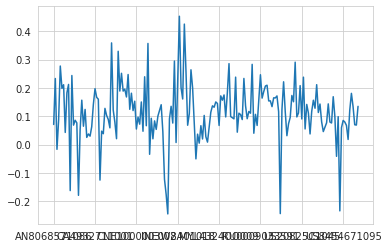

In [153]:
df_q6['AAR'].plot()

<Axes: >

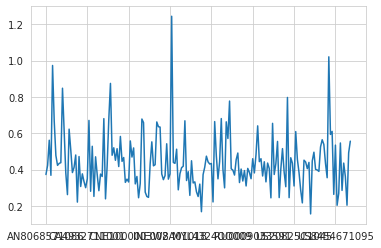

In [154]:
df_q6['volatility'].plot()

In [155]:
# correlation between individual average returns and volatility
corr_aar_vol = round(df_q6['AAR'].corr(df_q6['volatility']), 6)
corr_aar_vol

0.106325

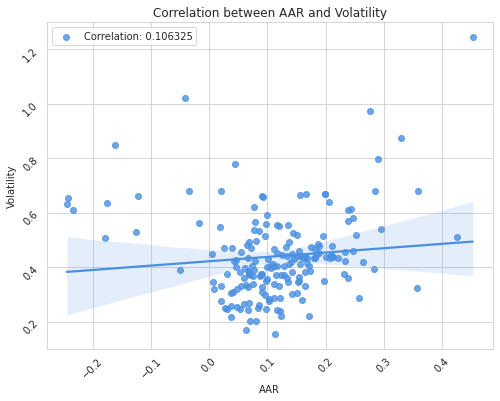

In [156]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Use the function regplot to make a scatterplot
sns.regplot(x=df_q6['AAR'], y=df_q6['volatility'], color='#4A90E2', seed=0)

# Add a title and axis labels
plt.title('Correlation between AAR and Volatility')
plt.xlabel('AAR')
plt.ylabel('Volatility')

# Customize the tick marks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.legend(labels=[f'Correlation: {corr_aar_vol}'])

# Change the background color
sns.set_style("whitegrid")

plt.show()

### Return - size correlation

<Axes: >

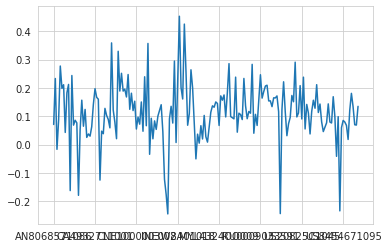

In [157]:
df_q6['AAR'].plot()

<Axes: >

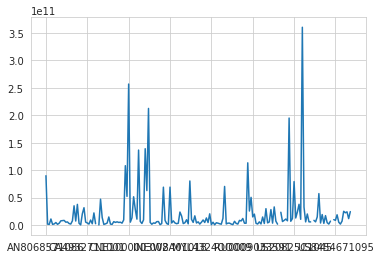

In [158]:
df_q6['cap'].plot()

In [159]:
# correlation between individual average returns and cap
corr_aar_cap = round(df_q6['AAR'].corr(df_q6['cap']), 6)
corr_aar_cap

-0.112418

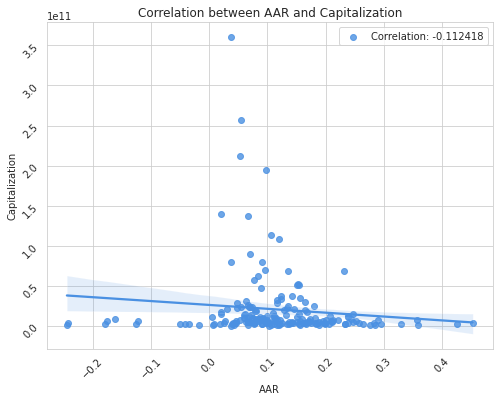

In [160]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Use the function regplot to make a scatterplot
sns.regplot(x=df_q6['AAR'], y=df_q6['cap'], color='#4A90E2', seed=0)

# Add a title and axis labels
plt.title('Correlation between AAR and Capitalization')
plt.xlabel('AAR')
plt.ylabel('Capitalization')

# Customize the tick marks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.legend(labels=[f'Correlation: {corr_aar_cap}'])

# Change the background color
sns.set_style("whitegrid")

plt.show()

### (Not required) Volatility - size correlation

In [161]:
# correlation between individual average returns and volatility
corr_vol_cap = round(df_q6['volatility'].corr(df_q6['cap']), 6)
corr_vol_cap

-0.301839

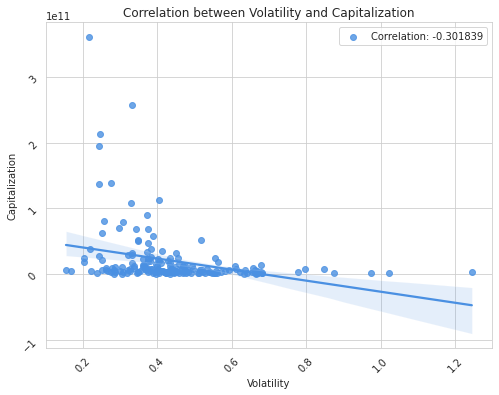

In [162]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Use the function regplot to make a scatterplot
sns.regplot(x=df_q6['volatility'], y=df_q6['cap'], color='#4A90E2', seed=0)

# Add a title and axis labels
plt.title('Correlation between Volatility and Capitalization')
plt.xlabel('Volatility')
plt.ylabel('Capitalization')

# Customize the tick marks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.legend(labels=[f'Correlation: {corr_vol_cap}'])

# Change the background color
sns.set_style("whitegrid")

plt.show()

## Q7

In [163]:
# get datasets, copied from those from Q3
df_q7_ret = df_q3_ret.copy()
df_q7_ret_2015 = df_q3_ret_2015.copy()
df_q7_100_sorted = df_q3_100_sorted.copy()
df_q7_100_sorted_2015 = df_q7_100_sorted[-7200:].reset_index(drop=True)

In [164]:
df_q7_100_sorted_2015

,date,year,month,ISIN,monthly_return,market_cap
0,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11
1,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10
2,2015-01-31,2015,1,AU000000AOE6,-0.036267,NaN
3,2015-01-31,2015,1,AU000000PDN8,0.101381,4.919250e+08
4,2015-01-31,2015,1,AU000000WOR2,-0.032755,1.824890e+09
...,...,...,...,...,...,...
7195,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10
7196,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10
7197,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10
7198,2020-12-31,2020,12,US98385X1063,0.000000,NaN


In [165]:
df_q7_100_sorted_top67 = pd.DataFrame()

# for each month, keep only top 66.6667 %
for m in range(len(df_q7_ret)):
    start = m*100
    end = start + 100
    top67 = df_q7_100_sorted.iloc[start:end].sort_values(['market_cap'],ascending=False).iloc[:-33].sort_values(['date','ISIN'])
    df_q7_100_sorted_top67 = pd.concat([df_q7_100_sorted_top67, top67], ignore_index=True)
df_q7_100_sorted_top67

,date,year,month,ISIN,monthly_return,market_cap
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN
1,2005-01-31,2005,1,ARP9897X1319,0.028704,NaN
2,2005-01-31,2005,1,AU000000AOE6,-0.087586,NaN
3,2005-01-31,2005,1,AU000000PDN8,-0.058855,NaN
4,2005-01-31,2005,1,AU000000WOR2,0.053326,NaN
...,...,...,...,...,...,...
12859,2020-12-31,2020,12,US8454671095,0.068840,2.004840e+09
12860,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10
12861,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10
12862,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10


In [166]:
# build rolling cov_mat

df_q7_ret[df_q7_100_sorted_top67[7973 :8040].ISIN.tolist()].rolling(window=120).cov().iloc[8040:]

AN8068571086  ARP9897X1319  BMG2108M2182  \
date                                                                
2015-01-31 AN8068571086      0.009855      0.003047      0.003810   
           ARP9897X1319      0.003047      0.014883      0.002983   
           BMG2108M2182      0.003810      0.002983      0.013870   
           BMG5320C1082      0.005753      0.003536      0.004334   
           CA00208D4084      0.005452      0.003246      0.002864   
...                               ...           ...           ...   
2020-12-31 US8454671095      0.007079      0.005099     -0.000095   
           US9026531049      0.003105      0.001618      0.001125   
           US91913Y1001      0.009317      0.008396      0.003435   
           US9694571004      0.007397      0.006826      0.002138   
           ZAE000006896      0.012824      0.012625      0.006307   

                         BMG5320C1082  CA00208D4084  CA07317Q1054  \
date                                                                
2015-01-31 AN8068571086      0.005753      0.005452      0.007887   
           ARP9897X1319      0.003536      0.003246      0.004781   
           BMG2108M2182      0.004334      0.002864      0.003509   
           BMG5320C1082      0.018965      0.004618      0.008156   
           CA00208D4084      0.004618      0.009233      0.008572   
...                               ...           ...           ...   
2020-12-31 US8454671095      0.003324      0.010680      0.010996   
           US9026531049      0.001872      0.001492      0.004756   
           US91913Y1001      0.004722      0.006002      0.011460   
           US9694571004      0.002898      0.006251      0.010387   
           ZAE000006896      0.008258      0.011188      0.022036   

                         CA13321L1085  CA22576C1014  CA7063271034  \
date                                                                
2015-01-31 AN8068571086      0.007134      0.005992      0.003206   
           ARP9897X1319      0.003655      0.003548      0.002021   
           BMG2108M2182      0.003227      0.003992      0.002407   
           BMG5320C1082      0.007687      0.005858      0.003016   
           CA00208D4084      0.007312      0.006818      0.003638   
...                               ...           ...           ...   
2020-12-31 US8454671095      0.005828      0.010931      0.005090   
           US9026531049      0.001558      0.003584      0.002678   
           US91913Y1001      0.005302      0.011398      0.005572   
           US9694571004      0.003427      0.009317      0.005882   
           ZAE000006896      0.007406      0.021692      0.011214   

                         CA8672241079  ...  US6550441058  US6745991058  \
date                                   ...                               
2015-01-31 AN8068571086      0.008180  ...      0.006385      0.006146   
           ARP9897X1319      0.004000  ...      0.003092      0.003282   
           BMG2108M2182      0.005202  ...      0.002967      0.003929   
           BMG5320C1082      0.008412  ...      0.005152      0.005377   
           CA00208D4084      0.007080  ...      0.005640      0.005537   
...                               ...  ...           ...           ...   
2020-12-31 US8454671095      0.004721  ...      0.008599      0.006340   
           US9026531049      0.003215  ...      0.003071      0.004345   
           US91913Y1001      0.007701  ...      0.008614      0.009932   
           US9694571004      0.005772  ...      0.008112      0.007090   
           ZAE000006896      0.009207  ...      0.015379      0.015886   

                         US6752321025  US69047Q1022  US7237871071  \
date                                                                
2015-01-31 AN8068571086      0.008686      0.005447      0.009350   
           ARP9897X1319      0.003109      0.003615      0.004339   
           BMG2108M2182      0.003548      0.003521      0.003636   
           BMG5320C1082

In [167]:
# optimal min var weights

min_var_weights = []

# do the same as Q3 except with top two thirds
for m in range(len(df_q7_ret_2015)):
    
  cov_start = m*67
  cov_end = cov_start + 67
 
  # get cov mat -> 7973 instead of 8040 to get month t-1
  a = df_q7_ret[df_q7_100_sorted_top67[7973 + cov_start:7973 + cov_end].ISIN.tolist()].rolling(window=120).cov().iloc[8040:]
  
  month_cov_mat = a[cov_start:cov_end]

  inv_cov = np.linalg.inv(month_cov_mat)


  def objective(weights, month_cov_mat):
      return weights.T @ month_cov_mat @ weights

  def constraint1(weights):
      return np.sum(weights) - 1

  constraints = [{'type': 'eq', 'fun': constraint1}]

  bounds = tuple((0, 1) for x in range(67))

  weights = np.ones(67) / 67

  result = minimize(objective, weights, args=month_cov_mat, constraints=constraints, bounds=bounds)

  month_weights = result.x / np.sum(result.x)

  month_weights = list(month_weights)

  min_var_weights.append(month_weights)

In [168]:
len(min_var_weights)

72

In [169]:
len(min_var_weights[0])

67

In [170]:
df_min_var_weights = pd.DataFrame()

for i in range(len(min_var_weights)):
  
  month_weights = pd.Series(min_var_weights[i])
  df_min_var_weights = pd.concat([df_min_var_weights, month_weights], ignore_index=True)
  
df_min_var_weights.columns.values[0] = "min_var_weights"
df_min_var_weights

,min_var_weights
0,1.903635e-18
1,0.000000e+00
2,5.616666e-18
3,0.000000e+00
4,4.377771e-18
...,...
4819,1.391977e-18
4820,1.402093e-01
4821,2.704211e-19
4822,0.000000e+00


In [171]:
#Adding the weights to a newly created dataframe with only top 67 firms per month
df_q7_100_sorted_2015_top67 = df_q7_100_sorted_top67[-4824:].reset_index(drop=True)
df_q7_100_sorted_2015_top67['mv_weights'] = df_min_var_weights.min_var_weights

In [172]:
#computing the monthly returns for each ISIN based on the market cap weight per month
df_q7_100_sorted_2015_top67['mv_assets_monthly_weighted_returns'] = df_q7_100_sorted_2015_top67['monthly_return']*df_q7_100_sorted_2015_top67['mv_weights']

#computing the AAR of the minvar-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 16 years of data
df_q7_100_sorted_2015_top67['mv_AAR'] = (df_q7_100_sorted_2015_top67['mv_assets_monthly_weighted_returns'].sum())/6

#computing the annual return of the value-weighted portfolio 
annual_return_df = df_q7_100_sorted_2015_top67[['year','mv_assets_monthly_weighted_returns']].groupby('year').sum()
def annual_return_func(row):
    year = row['year']
    return annual_return_df.loc[(year)][0]
df_q7_100_sorted_2015_top67['mv_annual_return'] = df_q7_100_sorted_2015_top67.apply(annual_return_func, axis=1)

#computing the monthly return of the value-weighted portfolio 
monthly_returns_df = df_q7_100_sorted_2015_top67[['year','month','mv_assets_monthly_weighted_returns']].groupby(['year','month']).sum()

def monthly_returns_func(row):
    year = row['year']
    month = row['month']
    return monthly_returns_df.loc[(year,month)][0]

df_q7_100_sorted_2015_top67['mv_monthly_returns'] = df_q7_100_sorted_2015_top67.apply(monthly_returns_func, axis=1)

# computing portfolio volatility
df_q7_100_sorted_2015_top67['mv_annualized_volatility'] = df_q7_100_sorted_2015_top67['mv_monthly_returns'].std()*math.sqrt(12)

df_q7_100_sorted_2015_top67

,date,year,month,ISIN,monthly_return,market_cap,mv_weights,mv_assets_monthly_weighted_returns,mv_AAR,mv_annual_return,mv_monthly_returns,mv_annualized_volatility
0,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,1.903635e-18,1.279101e-20,0.124194,0.112346,0.059261,0.135378
1,2015-01-31,2015,1,ARP9897X1319,-0.164872,1.316640e+10,0.000000e+00,-0.000000e+00,0.124194,0.112346,0.059261,0.135378
2,2015-01-31,2015,1,BMG2108M2182,0.231498,6.139960e+09,5.616666e-18,1.300247e-18,0.124194,0.112346,0.059261,0.135378
3,2015-01-31,2015,1,BMG5320C1082,-0.075595,8.403860e+09,0.000000e+00,-0.000000e+00,0.124194,0.112346,0.059261,0.135378
4,2015-01-31,2015,1,CA00208D4084,-0.045357,6.094150e+09,4.377771e-18,-1.985629e-19,0.124194,0.112346,0.059261,0.135378
...,...,...,...,...,...,...,...,...,...,...,...,...
4819,2020-12-31,2020,12,US8454671095,0.068840,2.004840e+09,1.391977e-18,9.582367e-20,0.124194,0.156098,0.068018,0.135378
4820,2020-12-31,2020,12,US9026531049,0.178104,1.131690e+10,1.402093e-01,2.497181e-02,0.124194,0.156098,0.068018,0.135378
4821,2020-12-31,2020,12,US91913Y1001,0.388083,2.306860e+10,2.704211e-19,1.049459e-19,0.124194,0.156098,0.068018,0.135378
4822,2020-12-31,2020,12,US9694571004,0.113479,2.433240e+10,0.000000e+00,0.000000e+00,0.124194,0.156098,0.068018,0.135378


In [173]:
# other statistics
mv_min_top67 = df_q7_100_sorted_2015_top67['mv_annual_return'].min()
mv_max_top67 = df_q7_100_sorted_2015_top67['mv_annual_return'].max()
mv_sharperatio_top67 = (df_q7_100_sorted_2015_top67['mv_AAR'].mean()- risk_free_rate)/df_q7_100_sorted_2015_top67['mv_annualized_volatility'].mean()
mv_AAR_top67 = (df_q7_100_sorted_2015_top67['mv_assets_monthly_weighted_returns'].sum())/6
mv_volatility_top67 = df_q7_100_sorted_2015_top67['mv_monthly_returns'].std()*math.sqrt(12)

In [174]:
# Generate sample data
x = df_q3_100_sorted_2015.groupby('year').year.mean()
y1 = df_q3_100_sorted_2015.groupby('year').mv_annual_return.mean()
y2 = df_q7_100_sorted_2015_top67.groupby('year').mv_annual_return.mean()

# Create figure
fig = go.Figure()

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1, name='Minimum variance portfolio annual returns', line=dict(color='lightblue', width=5)))
fig.add_trace(go.Scatter(x=x, y=y2, name='Top two-thirds minimum variance portfolio annual returns', line=dict(color='red', width=5)))


# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=16),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=18), side='top')),
                  legend_title_font=dict(size=18),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year', font=dict(size=22), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()

In [175]:
# Create a new table
table = prettytable.PrettyTable()

# Add the columns to the table
table.field_names = ['Portfolio','Minimum variance portfolio','Top two-thirds minimum variance portfolio']

# Add the rows to the table
tabledf={
    'Annualized average return': ['Annualized average return (%)',round(mv_AAR*100,3), round(mv_AAR_top67*100,3)],
    'Annualized Volatility': ['Annualized volatility (%)',round(mv_volatility*100,3), round(mv_volatility_top67*100,3)],
    'Minimum return': ['Minimum return (%)',round(mv_min*100,3), round(mv_min_top67*100,3)],
    'Maximum return': ['Maximum return (%)',round(mv_max*100,3), round(mv_max_top67*100,3)],
    'Sharpe Ratio': ['Sharpe Ratio',round(mv_sharperatio,3), round(mv_sharperatio_top67,3)]
}

for row in tabledf:
    table.add_row(tabledf[row])

# Add borders to the table
table.hrules = prettytable.ALL
table.header = True
table.set_style(prettytable.SINGLE_BORDER)

# Save the table to a file
with open('minvar_TopTwoThirds.txt', 'w') as f:
    f.write(str(table))
    
# Display the table
print(table)

┌───────────────────────────────┬────────────────────────────┬───────────────────────────────────────────┐
│           Portfolio           │ Minimum variance portfolio │ Top two-thirds minimum variance portfolio │
├───────────────────────────────┼────────────────────────────┼───────────────────────────────────────────┤
│ Annualized average return (%) │           4.735            │                   12.419                  │
├───────────────────────────────┼────────────────────────────┼───────────────────────────────────────────┤
│   Annualized volatility (%)   │           6.517            │                   13.538                  │
├───────────────────────────────┼────────────────────────────┼───────────────────────────────────────────┤
│       Minimum return (%)      │           1.861            │                   9.521                   │
├───────────────────────────────┼────────────────────────────┼───────────────────────────────────────────┤
│       Maximum return (%)      │    